/var/folders/3k/xw7yft_156g1vhdnxbnt3q580000gn/T/ipykernel_15969/143092035.py:1263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axH.legend(loc="upper left", ncol=2, fontsize=8)


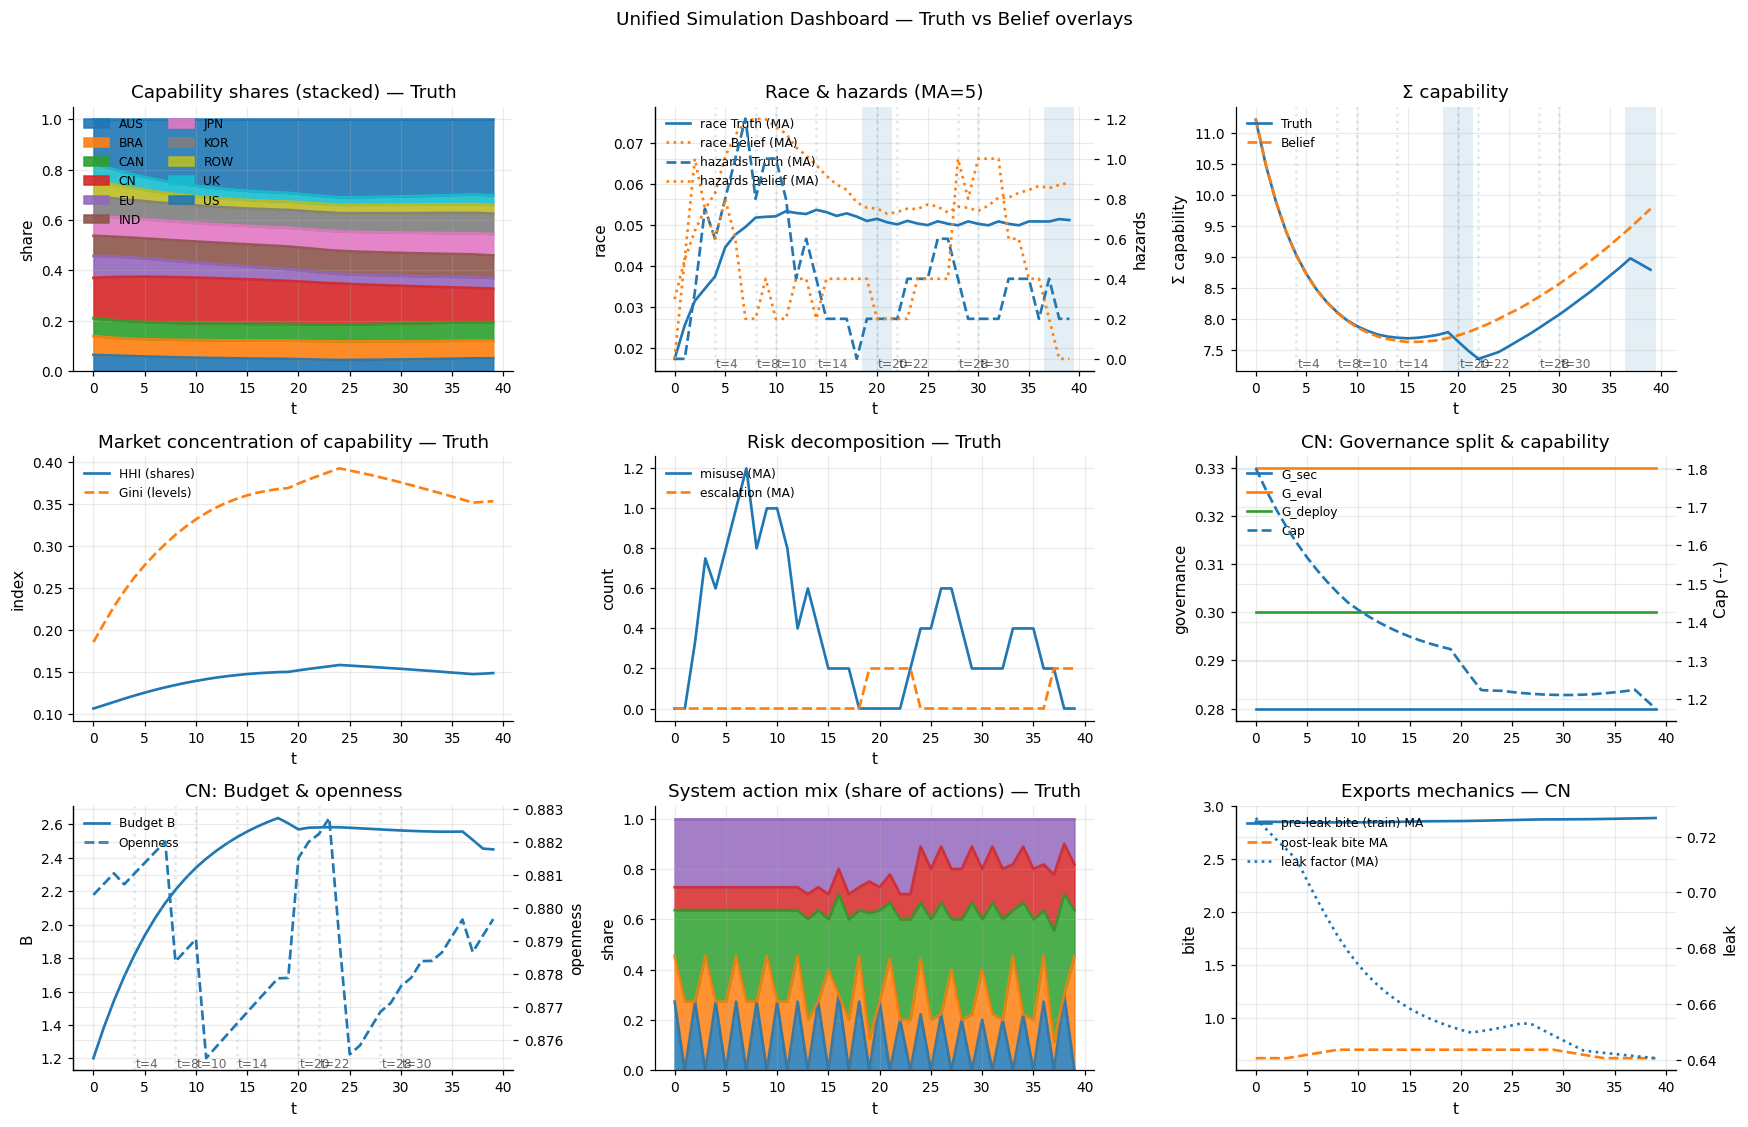

/var/folders/3k/xw7yft_156g1vhdnxbnt3q580000gn/T/ipykernel_15969/143092035.py:1943: RuntimeWarning: invalid value encountered in scalar divide
  b = (X*Y).sum() / (X*X).sum()  # OLS slope on standardized vars
/var/folders/3k/xw7yft_156g1vhdnxbnt3q580000gn/T/ipykernel_15969/143092035.py:1948: RuntimeWarning: invalid value encountered in scalar divide
  boot.append((xb*yb).sum() / (xb*xb).sum())
/var/folders/3k/xw7yft_156g1vhdnxbnt3q580000gn/T/ipykernel_15969/143092035.py:1943: RuntimeWarning: invalid value encountered in scalar divide
  b = (X*Y).sum() / (X*X).sum()  # OLS slope on standardized vars
/var/folders/3k/xw7yft_156g1vhdnxbnt3q580000gn/T/ipykernel_15969/143092035.py:1948: RuntimeWarning: invalid value encountered in scalar divide
  boot.append((xb*yb).sum() / (xb*xb).sum())
/var/folders/3k/xw7yft_156g1vhdnxbnt3q580000gn/T/ipykernel_15969/143092035.py:1943: RuntimeWarning: invalid value encountered in scalar divide
  b = (X*Y).sum() / (X*X).sum()  # OLS slope on standardized va

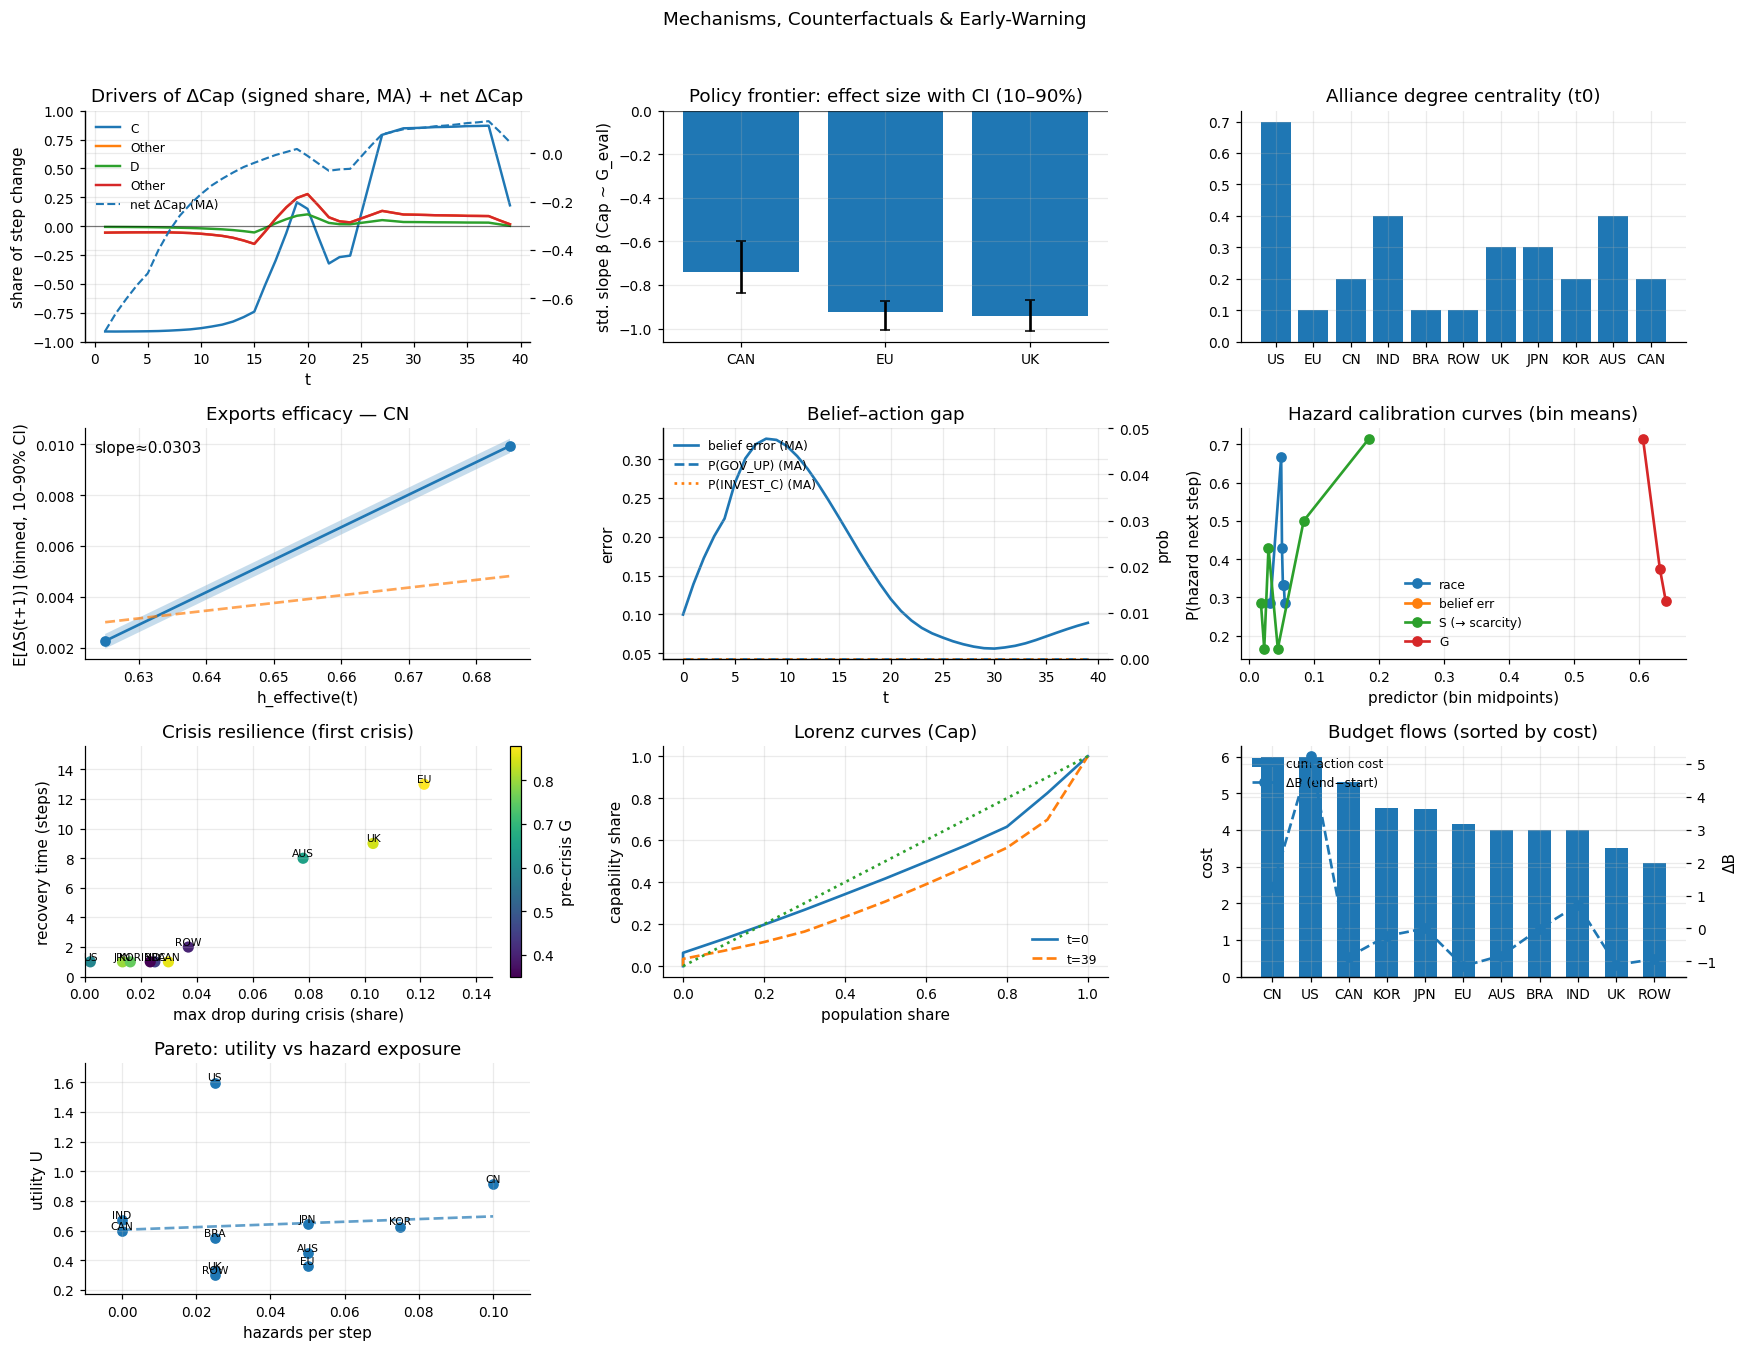

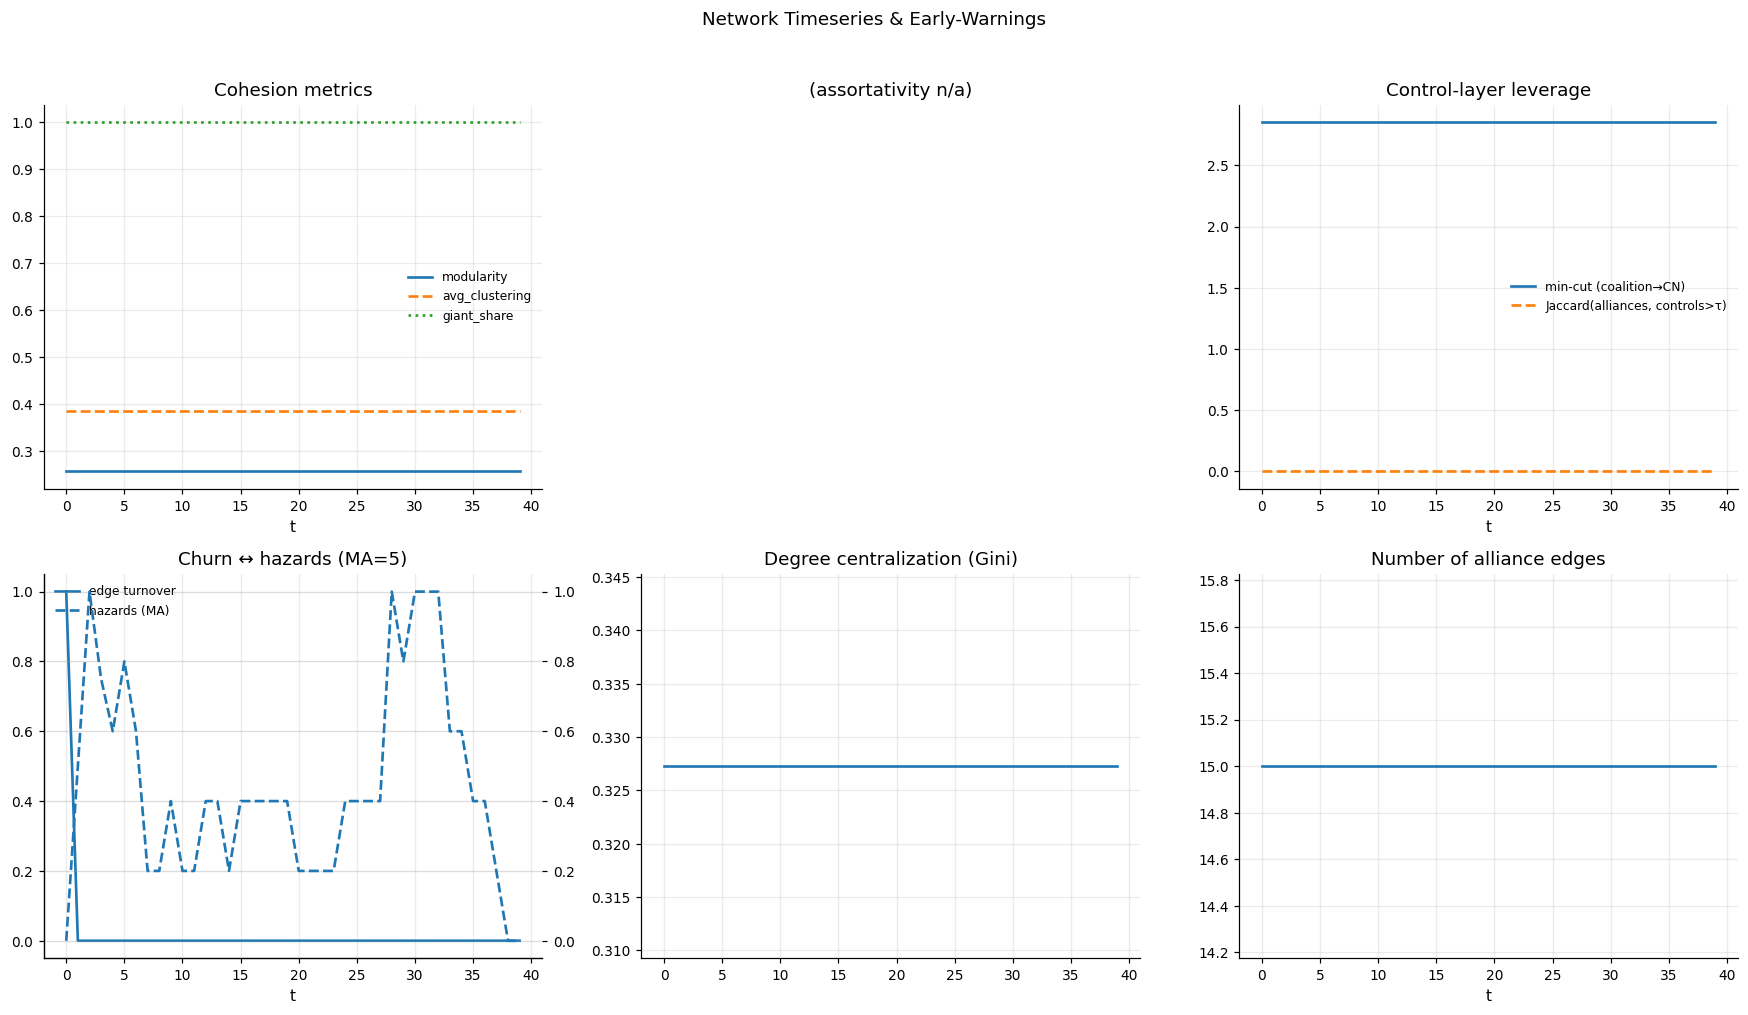

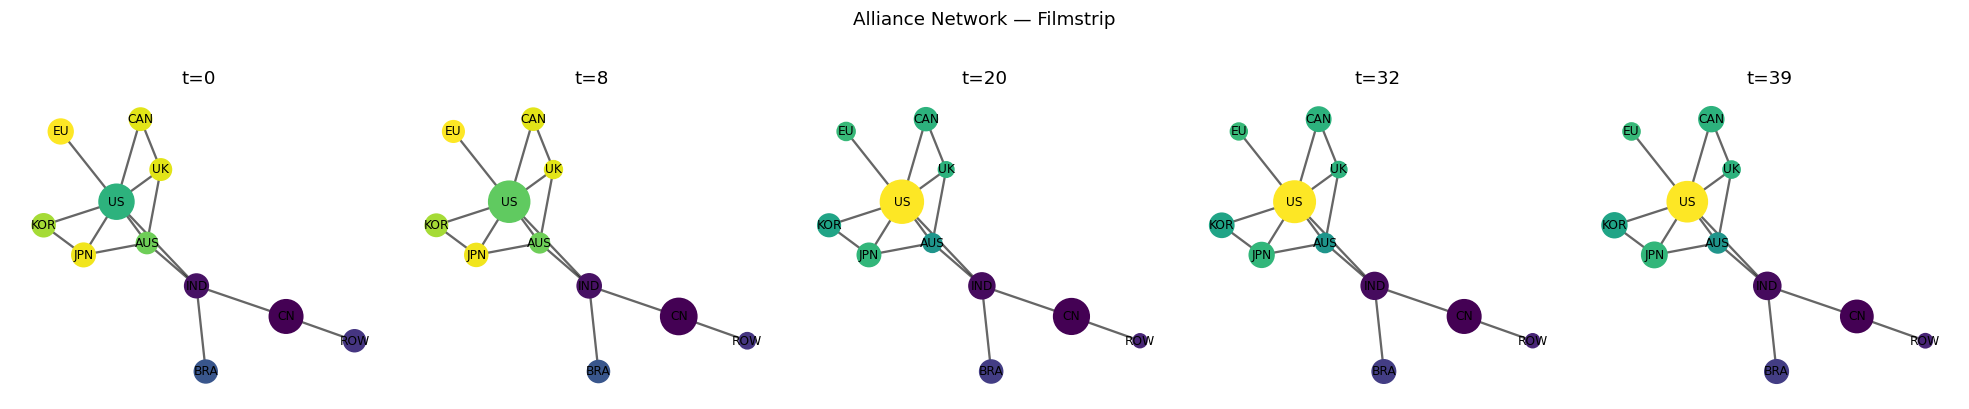

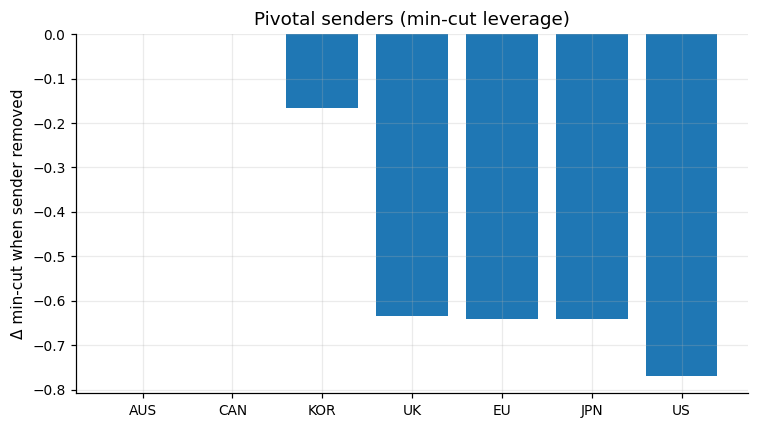

In [1]:
# Geo-AI Stochastic Game — v0.9 (refactored/compacted)
# - Keeps behavior; trims repetition and centralizes patterns.

from __future__ import annotations
import dataclasses as dc
from dataclasses import dataclass, field as dc_field
from typing import Dict, List, Set, Tuple, Callable, Optional, Deque
from collections import deque, defaultdict
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# Action / Policy primitives
# -------------------------------
INVEST_C = "invest_compute"
INVEST_D = "invest_data"
INVEST_E = "invest_energy"

# Back-compat (mapped below):
GOV_UP     = "governance_up"
GOV_DOWN   = "governance_down"

# New granular governance actions
GOV_UP_SEC      = "governance_up_security"
GOV_UP_EVAL     = "governance_up_eval"
GOV_UP_DEPLOY   = "governance_up_deploy"
GOV_DOWN_SEC    = "governance_down_security"
GOV_DOWN_EVAL   = "governance_down_eval"
GOV_DOWN_DEPLOY = "governance_down_deploy"

# -------------------------------
# Small helpers (used widely)
# -------------------------------
def _rate_per_step(annual_rate: float, steps_per_year: int) -> float:
    return (1.0 + float(annual_rate))**(1.0/steps_per_year) - 1.0

def _expit(x: float) -> float:
    return 1.0 / (1.0 + np.exp(-x))

def _logit(x: float, eps: float = 1e-9) -> float:
    x = np.clip(x, eps, 1.0 - eps)
    return np.log(x / (1.0 - x))

def _gini(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    if x.size == 0 or np.allclose(x.sum(), 0.0): return np.nan
    x = np.sort(x); n = len(x); cum = np.cumsum(x)
    return float((n + 1 - 2 * np.sum(cum) / cum[-1]) / n)

def clip01(x: float, eps: float = 0.0) -> float:
    return float(np.clip(x, 0.0 + eps, 1.0 - eps if eps else 1.0))

def mean_or0(seq) -> float:
    return float(np.mean(seq)) if seq else 0.0

def moving_avg(s: pd.Series, w=5) -> pd.Series:
    return s.rolling(w, min_periods=1).mean()

def legend_merge(ax, ax2, loc="upper left", fontsize=8):
    h1, n1 = ax.get_legend_handles_labels()
    h2, n2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, n1 + n2, loc=loc, fontsize=fontsize)

def get_map(maybe_map, key, default):
    return (maybe_map or {}).get(key, default)

# Governance action maps
G_UP = {GOV_UP_SEC:"G_sec", GOV_UP_EVAL:"G_eval", GOV_UP_DEPLOY:"G_deploy"}
G_DN = {GOV_DOWN_SEC:"G_sec", GOV_DOWN_EVAL:"G_eval", GOV_DOWN_DEPLOY:"G_deploy"}
LEGACY = {GOV_UP: GOV_UP_EVAL, GOV_DOWN: GOV_DOWN_DEPLOY}
UP_VARIANTS, DN_VARIANTS = set(G_UP), set(G_DN)

def _apply_gov_delta(s, acts: Set[str], dG: float):
    for act, attr in G_UP.items():
        if act in acts: setattr(s, attr, clip01(getattr(s, attr) + dG))
    for act, attr in G_DN.items():
        if act in acts: setattr(s, attr, clip01(getattr(s, attr) - dG))

# -------------------------------
# Config & Parameters
# -------------------------------
@dataclass
class Weights:
    w_eta: float = 0.20
    w_C:   float = 0.55
    w_D:   float = 0.15
    w_E:   float = 0.07
    w_S:   float = 0.03
    omega_E: float = 1.0
    omega_S: float = 1.0
    omega_B: float = 1.0
    omega_R: float = 0.0
    def norm_cap_weights(self) -> Tuple[float,float,float,float,float]:
        s = self.w_eta + self.w_C + self.w_D + self.w_E + self.w_S
        if s <= 0: return (0.0,1.0,0.0,0.0,0.0)
        return (self.w_eta/s, self.w_C/s, self.w_D/s, self.w_E/s, self.w_S/s)

@dataclass
class Rates:
    gC_base: float = 0.045
    gD_base: float = 0.025
    gE_base: float = 0.020
    beta_C: float = 0.75
    beta_D: float = 0.50
    beta_E: float = 0.40
    kappa_G: float = 0.15
    learn_zeta: float = 0.020
    learn_lambda: float = 1.00
    Delta_G: float = 0.05
    lambda_A: float = 0.03
    a_trust: float = 0.60
    a_gov:   float = 0.40
    a_press: float = 0.75
    a_bias:  float = 0.00
    lam_cap: float = 0.15
    k_belief_damp: float = 0.75
    alpha_R: float = 0.08
    rho_race: float = 0.60
    lambda_mis: float = 0.05
    lambda_esc: float = 0.03
    theta_G_mis: float = 0.55
    theta_G_esc: float = 0.45
    theta_R: float = 0.20
    theta_R2: float = 0.40
    theta_Scarcity: float = 0.30
    theta_BeliefErr: float = 0.25
    pmax: float = 0.20
    gamma_X: float = 0.35
    s_regrow: float = 0.02
    lambda_leak: float = 0.25
    h_cap: float = 0.70
    phi_subst: float = 0.07
    subst_norm: float = 3.0
    xi_S: float = 0.30
    E_norm: float = 0.90
    crisis_steps: int = 3
    crisis_growth_mult: float = 0.96
    crisis_hazard_mult: float = 1.25
    scars_steps: int = 2
    scars_budget_mult: float = 0.98
    scars_s_regrow_mult: float = 0.50
    rho_B: float = 0.95
    k_pi:  float = 0.60
    chi_B: float = 1.00
    export_fee_share: float = 0.0
    export_fee_scale: float = 0.0
    s_pipeline_tau: int = 4
    s_pipeline_base: float = 0.01
    target_S: float = 0.98
    k_backlog: float = 0.04
    r_up: float = 0.01
    r_down: float = 0.01
    r_mis: float = 0.02
    r_esc: float = 0.05
    r_decay: float = 0.995
    k_open: float = 0.20
    w_choke_train: Dict[str, float] = dc_field(default_factory=lambda: {"EDA":0.20,"LITHO":0.35,"HBM":0.35,"CLOUD":0.10})
    w_choke_infer: Dict[str, float] = dc_field(default_factory=lambda: {"EDA":0.10,"LITHO":0.15,"HBM":0.35,"CLOUD":0.40})
    regime_bite: Dict[str, float] = dc_field(default_factory=lambda: {"OPEN":0.00, "CARVEOUT":0.20, "LICENSE_FEE":0.45, "BAN":0.85})
    phi_subst_train: float = 0.04
    phi_subst_infer: float = 0.14
    fat_tail_p: float = 0.08
    fat_tail_alpha: float = 2.2
    fat_tail_scale: float = 1.75
    hysteresis_steps: int = 6
    hysteresis_mult: float = 1.20

@dataclass
class Exogenous:
    eta_series: Optional[np.ndarray] = None

@dataclass
class Flags:
    terminal_on_escalation: bool = False
    enable_alliance_sharing: bool = True
    enable_dynamic_alliances: bool = False
    enable_exports: bool = True
    enable_governance_slowdown: bool = True
    enable_crisis_mode: bool = True
    enable_observation_asymmetry: bool = True
    use_belief_Gsec_in_hazards: bool = False  # if True, hazards use perceived G_sec

@dataclass
class Heterogeneity:
    beta_C: Dict[str, float] = dc_field(default_factory=dict)
    kappa_G: Dict[str, float] = dc_field(default_factory=dict)
    xi_S: Dict[str, float] = dc_field(default_factory=dict)
    gamma_X: Dict[str, float] = dc_field(default_factory=dict)
    K_D: Dict[str, float] = dc_field(default_factory=dict)
    K_E: Dict[str, float] = dc_field(default_factory=dict)
    E_norm: Dict[str, float] = dc_field(default_factory=dict)
    w_eta: Dict[str, float] = dc_field(default_factory=dict)
    w_C:   Dict[str, float] = dc_field(default_factory=dict)
    w_D:   Dict[str, float] = dc_field(default_factory=dict)
    w_E:   Dict[str, float] = dc_field(default_factory=dict)
    w_S:   Dict[str, float] = dc_field(default_factory=dict)
    omega_E: Dict[str, float] = dc_field(default_factory=dict)
    omega_S: Dict[str, float] = dc_field(default_factory=dict)
    omega_B: Dict[str, float] = dc_field(default_factory=dict)
    omega_R: Dict[str, float] = dc_field(default_factory=dict)
    openness_bias: Dict[str, float] = dc_field(default_factory=dict)
    export_sender_power: Dict[str, float] = dc_field(default_factory=dict)
    hazard_sensitivity: Dict[str, float] = dc_field(default_factory=dict)
    cost_Gup_mult: Dict[str, float] = dc_field(default_factory=dict)
    cost_Gdown_mult: Dict[str, float] = dc_field(default_factory=dict)

@dataclass
class Config:
    actors: List[str]
    T: int = 40
    weights: Weights = dc_field(default_factory=Weights)
    rates: Rates = dc_field(default_factory=Rates)
    flags: Flags = dc_field(default_factory=Flags)
    het: Heterogeneity = dc_field(default_factory=Heterogeneity)
    epsilon: float = 1e-9
    seed: int = 42
    time_unit: str = "quarter"
    steps_per_year: int = 4
    C0: Dict[str, float] = dc_field(default_factory=dict)
    D0: Dict[str, float] = dc_field(default_factory=dict)
    E0: Dict[str, float] = dc_field(default_factory=dict)
    G0: Dict[str, float] = dc_field(default_factory=dict)
    S0: Dict[str, float] = dc_field(default_factory=dict)
    B0: Dict[str, float] = dc_field(default_factory=dict)
    R0: Dict[str, float] = dc_field(default_factory=dict)
    K_D: float = 3.0
    K_E: float = 3.0
    A0_edges: List[Tuple[str,str]] = dc_field(default_factory=list)
    X0: Optional[pd.DataFrame] = None
    X_regimes: Dict[Tuple[str,str], Dict[str,str]] = dc_field(default_factory=dict)
    chokepoints: Tuple[str,...] = ("EDA","LITHO","HBM","CLOUD")
    exog: Exogenous = dc_field(default_factory=Exogenous)
    sigma_self: float = 0.00
    sigma_ally: float = 0.05
    sigma_rival: float = 0.15
    mu_bias_rival: float = 0.00
    obs_lag: int = 1
    sigma_self_map: Optional[Dict[str, float]] = None
    sigma_ally_map: Optional[Dict[str, float]] = None
    sigma_rival_map: Optional[Dict[str, float]] = None
    mu_bias_map: Optional[Dict[Tuple[str,str], float]] = None
    obs_lag_map: Optional[Dict[str, int]] = None
    belief_beta_map: Optional[Dict[str, float]] = None
    belief_beta: float = 0.80
    cost_C: float = 0.15
    cost_D: float = 0.10
    cost_E: float = 0.10
    cost_Gup: float = 0.05
    cost_Gdown: float = 0.05
    events: List[dict] = dc_field(default_factory=list)
    gpaith_enabled: bool = True
    gpaith_cap_threshold: float = 3.0
    gpaith_delta_G: float = 0.10
    gpaith_sigma_scale: float = 0.85
    gpaith_cost_bump: float = 0.02
    gpaith_subjects: Optional[List[str]] = None

# -------------------------------
# State & Logs
# -------------------------------
@dataclass
class ActorState:
    C: float; D: float; E: float
    G_sec: float; G_eval: float; G_deploy: float
    S: float
    S_backlog: Deque[float] = dc_field(default_factory=deque)
    B: float = 1.0
    R: float = 0.0
    @property
    def G(self) -> float:
        return (self.G_sec + self.G_eval + self.G_deploy) / 3.0

@dataclass
class StepLog:
    t: int; actor: str
    C: float; D: float; E: float; G: float; S: float; B: float; R: float
    Cap: float; Econ: float; Strat: float; Stab: float; U: float
    misuse: int; escalation: int; crisis_active: int
    actions: str; action_cost: float
    race_intensity: float; total_capability: float
    incoming_controls: float; leak_factor: float
    openness: float
    belief_Cap: float; belief_S: float; belief_G: float
    h_effective: float; deliveries_eff: float
    belief_error: float
    G_sec: float; G_eval: float; G_deploy: float; belief_G_sec: float = np.nan

# -------------------------------
# Engine
# -------------------------------
class GeoAIGame:
    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)
        self.idx = {a:i for i,a in enumerate(cfg.actors)}
        self._gpaith_tripped: Set[str] = set()

        # Baselines per step
        self._gC_step = _rate_per_step(cfg.rates.gC_base, cfg.steps_per_year)
        self._gD_step = _rate_per_step(cfg.rates.gD_base, cfg.steps_per_year)
        self._gE_step = _rate_per_step(cfg.rates.gE_base, cfg.steps_per_year)

        # Init state
        def _get(d, a, default): return float(d.get(a, default))
        self.state: Dict[str, ActorState] = {}
        for a in cfg.actors:
            S0 = clip01(_get(cfg.S0, a, 0.8))
            tau = cfg.rates.s_pipeline_tau
            backlog = deque([cfg.rates.s_pipeline_base] * max(0, tau - 1), maxlen=max(0, tau - 1))
            g_base  = clip01(_get(cfg.G0, a, 0.5))
            g_sec   = clip01(getattr(cfg, "G0_sec", {}).get(a, g_base))
            g_eval  = clip01(getattr(cfg, "G0_eval", {}).get(a, g_base))
            g_deploy= clip01(getattr(cfg, "G0_deploy", {}).get(a, g_base))
            self.state[a] = ActorState(
                C=_get(cfg.C0, a, 1.0), D=_get(cfg.D0, a, 1.0), E=_get(cfg.E0, a, 1.0),
                G_sec=g_sec, G_eval=g_eval, G_deploy=g_deploy, S=S0, S_backlog=backlog,
                B=_get(cfg.B0, a, 1.0), R=_get(cfg.R0, a, 0.0)
            )
        
        # Alliances
        self.A = nx.Graph(); self.A.add_nodes_from(cfg.actors); self.A.add_edges_from(cfg.A0_edges)

        # Exports
        if cfg.X0 is not None:
            self.X = cfg.X0.copy().reindex(index=cfg.actors, columns=cfg.actors, fill_value=0.0)
        else:
            self.X = pd.DataFrame(0.0, index=cfg.actors, columns=cfg.actors)
        np.fill_diagonal(self.X.values, 0.0)

        # Build regimes from numeric X0 if needed
        self.X_regimes = dict(cfg.X_regimes) if cfg.X_regimes else {}
        for snd in cfg.actors:
            for tgt in cfg.actors:
                if snd == tgt: continue
                if float(self.X.loc[snd, tgt]) > 0.0 and (snd, tgt) not in self.X_regimes:
                    self.X_regimes[(snd, tgt)] = {cp: "LICENSE_FEE" for cp in cfg.chokepoints}

        # Exogenous eta
        self.eta = np.maximum(1.0, (cfg.exog.eta_series[:cfg.T] if cfg.exog.eta_series is not None else np.ones(cfg.T)))

        # Normalized weights
        self.w_eta, self.wC, self.wD, self.wE, self.wS = cfg.weights.norm_cap_weights()

        # Crisis & scars
        self.crisis_timer = 0
        self.scars: Dict[str,int] = {a:0 for a in cfg.actors}
        self._post_crisis_thaw = 0

        # Beliefs
        self.beliefs: Dict[str, Dict[str, Dict[str, float]]] = {a:{} for a in self.cfg.actors}
        for i in self.cfg.actors:
            self.beliefs[i] = {j: {"Cap": None, "S": None, "G": None, "G_sec": None} for j in self.cfg.actors}
        # Governance-up marginal cost tracker
        self._g_up_ctr = defaultdict(int)
        self.logs: List[StepLog] = []
        self._race_prev: float = 0.0

        # network + control logs
        self.net_logs = []     # node/global metrics per t
        self.edge_logs = []    # edge snapshots per t (for churn/persistence)
        self.ctrl_logs = []    # control-layer (export-regime) metrics per t

    # --- heterogeneity getters
    def _het(self, key: str, actor: str, default: float) -> float:
        het = getattr(self.cfg.het, key, None)
        if isinstance(het, dict) and actor in het: return float(het[actor])
        return float(default)

    def _hets(self, a: str, **defaults) -> dict:
        return {k: self._het(k, a, v) for k, v in defaults.items()}

    # --- capability
    def _capability(self, a: str, t: int) -> float:
        s = self.state[a]
        w_eta = self._het("w_eta", a, self.w_eta)
        wC    = self._het("w_C",   a, self.wC)
        wD    = self._het("w_D",   a, self.wD)
        wE    = self._het("w_E",   a, self.wE)
        wS    = self._het("w_S",   a, self.wS)
        return (self.eta[t] ** w_eta) * (s.C ** wC) * (s.D ** wD) * (s.E ** wE) * (max(s.S,self.cfg.epsilon) ** wS)

    # --- race intensity with inertia
    def _race_intensity(self, action_sets: Dict[str, Set[str]]) -> float:
        invests = sum(((INVEST_C in u)+(INVEST_D in u)+(INVEST_E in u)) for u in action_sets.values())
        n = max(1, len(self.cfg.actors))
        raw = self.cfg.rates.alpha_R * (float(invests) / n)
        rho = float(self.cfg.rates.rho_race)
        race = rho * self._race_prev + (1.0 - rho) * raw
        self._race_prev = race
        return race

    # --- observation helpers
    def _sigma_mu(self, i, j):
        cfg = self.cfg
        if i == j:
            return get_map(cfg.sigma_self_map, i, cfg.sigma_self), 0.0
        if self.A.has_edge(i, j):
            sigma = get_map(cfg.sigma_ally_map, i, cfg.sigma_ally)
            ally_bonus = 0.6 + 0.4 * min(self.state[i].G_eval, self.state[j].G_eval)
            return sigma * ally_bonus, 0.0
        return get_map(cfg.sigma_rival_map, i, cfg.sigma_rival), get_map(cfg.mu_bias_map, (i, j), cfg.mu_bias_rival)

    def _obs_for_actor(self, i: str, t: int) -> Dict[str, Dict[str, float]]:
        cfg = self.cfg
        tt = max(0, t - get_map(cfg.obs_lag_map, i, cfg.obs_lag))
        obs: Dict[str, Dict[str, float]] = {}
        for j in cfg.actors:
            s = self.state[j]
            sigma, mu = self._sigma_mu(i, j)
            C_hat = float(s.C * np.exp(self.rng.normal(mu, sigma)))
            D_hat = float(s.D * np.exp(self.rng.normal(mu, sigma)))
            E_hat = float(s.E * np.exp(self.rng.normal(mu, sigma)))
            S_hat = float(_expit(_logit(s.S, cfg.epsilon) + self.rng.normal(mu, sigma)))
            # NEW: observe security governance separately
            G_sec_hat = float(_expit(_logit(s.G_sec, cfg.epsilon) + self.rng.normal(mu, sigma)))
            # keep your eval-facing governance as "G" (back-compat)
            G_hat = float(_expit(_logit(s.G_eval, cfg.epsilon) + self.rng.normal(mu, sigma)))

            Cap_hat = (self.eta[tt] ** self.w_eta) * (C_hat ** self.wC) * (D_hat ** self.wD) * (E_hat ** self.wE) * (max(S_hat,cfg.epsilon) ** self.wS)
            obs[j] = {
                "C_hat": C_hat, "D_hat": D_hat, "E_hat": E_hat,
                "S": S_hat, "G": G_hat, "G_sec": G_sec_hat,   # <- include it
                "Cap_hat": float(Cap_hat),
            }
        return obs

    def _update_beliefs(self, i: str, obs_i: Dict[str, Dict[str,float]]):
        beta = (self.cfg.belief_beta_map or {}).get(i, self.cfg.belief_beta)
        for j in self.cfg.actors:
            b = self.beliefs[i][j]
            for kk, key in [("Cap_hat","Cap"), ("S","S"), ("G","G"), ("G_sec","G_sec")]:
                new = obs_i[j]["Cap_hat"] if kk == "Cap_hat" else obs_i[j][kk]
                b[key] = float(new) if b[key] is None else float(beta * b[key] + (1 - beta) * new)

    def _perceived_G_sec(self, a: str, default: float) -> float:
        vals = [
            self.beliefs[i][a].get("G_sec")
            for i in self.cfg.actors
            if self.beliefs[i][a].get("G_sec") is not None
        ]
        return float(np.mean(vals)) if vals else float(default)

    # --- policy decision hook (UNCHANGED signature; supports optional ally directives) ---
    def decide(self, t: int,
            policy: Optional[Callable[[int, Dict[str,ActorState]], Dict[str,dict]]] = None,
            policy_obs: Optional[Callable[[int, Dict[str,Dict[str,float]], str, Dict[str, Dict[str,float]]], Set[str]]] = None
            ) -> Dict[str, Dict[str, Set[str]]]:
        if policy_obs is not None and self.cfg.flags.enable_observation_asymmetry:
            decision: Dict[str, Dict[str, Set[str]]] = {}
            for a in self.cfg.actors:
                obs_i = self._obs_for_actor(a,t)
                self._update_beliefs(a, obs_i)
                acts = set(policy_obs(t, obs_i, a, self.beliefs[a]))
                decision[a] = {"actions": acts}  # ally_* may be injected by the caller's wrapper
            return decision
        assert policy is not None
        return policy(t, self.state)

    # --- optional dynamic alliances
    def _update_alliances(self):
        if not self.cfg.flags.enable_dynamic_alliances: return
        r = self.cfg.rates
        for i in range(len(self.cfg.actors)):
            for j in range(i+1, len(self.cfg.actors)):
                a, b = self.cfg.actors[i], self.cfg.actors[j]
                Ri, Rj = self.state[a].R, self.state[b].R
                Gi, Gj = self.state[a].G, self.state[b].G
                press = 0.5*(float(self.X.loc[a,b]) + float(self.X.loc[b,a])) if hasattr(self, "X") else 0.0
                sig = r.a_bias + r.a_trust*0.5*(Ri+Rj) + r.a_gov*min(Gi,Gj) - r.a_press*press
                p_on  = _expit(sig) * 0.15
                p_off = _expit(-sig) * 0.05
                if self.A.has_edge(a,b):
                    if self.rng.random() < p_off: self.A.remove_edge(a,b)
                else:
                    if self.rng.random() < p_on:  self.A.add_edge(a,b)

    # --- alliance diffusion helpers
    def _ally_press(self, i, j):
        return 0.5*(float(self.X.loc[i,j]) + float(self.X.loc[j,i])) if hasattr(self,"X") else 0.0

    def _alliance_diffusion(self, in_crisis: bool):
        cfg, r = self.cfg, self.cfg.rates
        if not (cfg.flags.enable_alliance_sharing and r.lambda_A>0) or in_crisis or self._post_crisis_thaw>0:
            return
        for i, j in self.A.edges():
            si, sj = self.state[i], self.state[j]
            sig = r.a_bias + r.a_trust*0.5*(si.R+sj.R) + r.a_gov*min(si.G_eval, sj.G_eval) - r.a_press*self._ally_press(i,j)
            lam_base = r.lambda_A * r.lam_cap * _expit(sig)
            Gi_bel = self.beliefs[i][j]["G"] or sj.G_eval
            Gj_bel = self.beliefs[j][i]["G"] or si.G_eval
            damp = float(np.clip(1.0 - r.k_belief_damp*(1.0 - min(Gi_bel, Gj_bel)), 0.25, 1.0))
            lam = lam_base * damp
            if lam <= 0: continue
            for attr in ("C","D","E"):
                vi, vj = getattr(si, attr), getattr(sj, attr)
                setattr(si, attr, (1-lam)*vi + lam*vj)
                setattr(sj, attr, (1-lam)*vj + lam*vi)

    # --- export/leakage helpers
    def _export_pressure(self, target: str) -> Tuple[float,float]:
        cfg, r = self.cfg, self.cfg.rates
        bite_train = bite_infer = 0.0
        for (snd, tgt), regmap in self.X_regimes.items():
            if tgt != target or snd == tgt: continue
            sender_weight = (1.0 + 0.3 * np.tanh(self.state[snd].R)) * self._het("export_sender_power", snd, 1.0)
            for cp in cfg.chokepoints:
                regime = regmap.get(cp, "OPEN")
                base = r.regime_bite.get(regime, 0.0)
                bite_train += sender_weight * base * r.w_choke_train.get(cp, 0.0)
                bite_infer += sender_weight * base * r.w_choke_infer.get(cp, 0.0)
        normT = max(1e-9, sum(r.w_choke_train.values()))
        normI = max(1e-9, sum(r.w_choke_infer.values()))
        return float(bite_train/normT), float(bite_infer/normI)

    def _leak_terms(self, a:str):
        r = self.cfg.rates
        allies = list(self.A.neighbors(a))
        leak_base = 1.0 - r.lambda_leak*(0.6*mean_or0([self.state[x].S for x in allies]) +
                                         0.4*mean_or0([self.state[k].S for k in self.cfg.actors if k!=a and k not in allies]))
        subst = min(1.0, (self.state[a].D + self.state[a].E) / max(r.subst_norm, self.cfg.epsilon))
        leakT = float(np.clip(leak_base*(1 - r.phi_subst_train*subst), 0.0, 1.0))
        leakI = float(np.clip(leak_base*(1 - r.phi_subst_infer*subst), 0.0, 1.0))
        return leakT, leakI, 0.5*(leakT+leakI)

    def _effective_bite(self, a:str, leakT:float, leakI:float):
        r = self.cfg.rates
        biteT, biteI = self._export_pressure(a)
        rep = 1.0 + (-0.2*np.tanh(self.state[a].R))
        hT = float(np.clip(biteT*leakT*rep, 0.0, r.h_cap))
        hI = float(np.clip(biteI*leakI*rep, 0.0, r.h_cap))
        return biteT, hT, hI

    # --- cost helper
    def _act_cost(self, a:str, act:str, base:dict, gup_mult:float, gdn_mult:float, surcharge:float)->float:
        c = base.get(act, 0.0)
        if act in UP_VARIANTS: c = c * gup_mult + surcharge
        if act in DN_VARIANTS: c = c * gdn_mult
        return c

    def _apply_event(self, ev: dict):
        kind = ev.get("fn",""); args = ev.get("args",{})
        if kind in {"override","shock"}:
            for scope, mapping in args.items():
                if scope in {"rates","flags"}:
                    for k, v in mapping.items(): setattr(getattr(self.cfg, scope), k, v)
                elif scope == "het":
                    for pkey, pd in mapping.items(): getattr(self.cfg.het, pkey).update(pd)
                elif scope == "obs":
                    for k, v in mapping.items():
                        cur = getattr(self.cfg, k, None)
                        if isinstance(cur, dict) and isinstance(v, dict): cur.update(v)
                        else: setattr(self.cfg, k, v)
                elif scope == "regimes":
                    for dyad, regmap in mapping.items():
                        self.X_regimes.setdefault(tuple(dyad), {}).update(regmap)
        elif kind == "edges":
            for e in args.get("add", []):
                if not self.A.has_edge(*e): self.A.add_edge(*e)
            for e in args.get("remove", []):
                if self.A.has_edge(*e): self.A.remove_edge(*e)

    def _log_network_metrics(self, t: int):
        import networkx as nx
        G = self.A
        n = len(G); m = G.number_of_edges()

        # node-level centralities
        deg = nx.degree_centrality(G)
        btw = nx.betweenness_centrality(G, normalized=True)
        try:
            eig = nx.eigenvector_centrality_numpy(G)
        except Exception:
            eig = {a: float("nan") for a in G.nodes()}

        # global cohesion
        giant_share = (max((len(c) for c in nx.connected_components(G)), default=0) / max(1, n)) if n else 0.0
        avg_clust   = nx.average_clustering(G) if n > 1 else float("nan")
        comms = list(nx.algorithms.community.greedy_modularity_communities(G)) if m else []
        modularity = nx.algorithms.community.quality.modularity(G, comms) if comms else 0.0

        # attribute assortativity (numeric): governance eval & supply security
        # NOTE: we log current values (pre-growth/hazards), good for EWI timing
        g_attr = {a: float(self.state[a].G_eval) for a in self.cfg.actors}
        s_attr = {a: float(self.state[a].S)      for a in self.cfg.actors}
        try:
            assort_g = nx.numeric_assortativity_coefficient(G, g_attr)
        except Exception:
            assort_g = float("nan")
        try:
            assort_s = nx.numeric_assortativity_coefficient(G, s_attr)
        except Exception:
            assort_s = float("nan")

        # append node metrics
        for a in G.nodes():
            self.net_logs += [
                {"t": t, "metric": "deg", "actor": a, "value": float(deg.get(a, 0))},
                {"t": t, "metric": "btw", "actor": a, "value": float(btw.get(a, 0))},
                {"t": t, "metric": "eig", "actor": a, "value": float(eig.get(a, float("nan")))},
            ]
        # append global metrics
        self.net_logs += [
            {"t": t, "metric": "giant_share",       "actor": "_", "value": float(giant_share)},
            {"t": t, "metric": "avg_clustering",    "actor": "_", "value": float(avg_clust)},
            {"t": t, "metric": "modularity",        "actor": "_", "value": float(modularity)},
            {"t": t, "metric": "assort_G_eval",     "actor": "_", "value": float(assort_g)},
            {"t": t, "metric": "assort_S",          "actor": "_", "value": float(assort_s)},
            {"t": t, "metric": "edges",             "actor": "_", "value": float(m)},
        ]

        # store edge snapshot for churn (as undirected sorted tuples)
        self.edge_logs.append({"t": t, "edges": sorted(tuple(sorted(e)) for e in G.edges())})


    def _control_graph(self):
        """Directed, weighted control layer from X_regimes (training bite expectation)."""
        import networkx as nx
        H = nx.DiGraph(); H.add_nodes_from(self.cfg.actors)
        r = self.cfg.rates; regbite = r.regime_bite
        for (snd, tgt), regmap in self.X_regimes.items():
            if snd == tgt: continue
            w = 0.0
            for cp, regime in regmap.items():
                w += r.w_choke_train.get(cp, 0.0) * regbite.get(regime, 0.0) * self._het("export_sender_power", snd, 1.0)
            if w > 0:
                H.add_edge(snd, tgt, w=float(w))
        return H


    def _log_control_metrics(self, t: int, coalition: Optional[Set[str]] = None, target: str = "CN", bite_thresh: float = 0.20):
        """Min-cut leverage & alliance–control overlap each step (handles dynamic regime updates)."""
        import networkx as nx
        coalition = set(coalition or {"US","EU","UK","JPN","KOR","AUS","CAN"})
        H = self._control_graph()

        # build residual graph with super-source to coalition
        SRC = "__SRC__"
        Gc = nx.DiGraph(); Gc.add_nodes_from(H.nodes())
        for u, v, d in H.edges(data=True):
            Gc.add_edge(u, v, capacity=float(d["w"]))
        Gc.add_node(SRC)
        for a in coalition:
            if a in Gc: Gc.add_edge(SRC, a, capacity=1e6)

        cut_val = 0.0
        try:
            cut_val, _ = nx.minimum_cut(Gc, SRC, target, capacity="capacity")
        except Exception:
            cut_val = float("nan")

        # overlap between alliance edges and "effective controls" (> threshold)
        # alliance: undirected; control>τ: make undirected shadow to score overlap
        A_und = set(tuple(sorted(e)) for e in self.A.edges())
        C_und = set(tuple(sorted((u, v))) for u, v, d in H.edges(data=True) if float(d["w"]) > bite_thresh)
        inter = len(A_und & C_und)
        union = len(A_und | C_und)
        jacc  = (inter / union) if union else float("nan")

        self.ctrl_logs += [
            {"t": t, "metric": "mincut_coalition_to_target", "actor": target, "value": float(cut_val)},
            {"t": t, "metric": "ally_control_jaccard",       "actor": "_",     "value": float(jacc)},
            {"t": t, "metric": "controls_edges_over_tau",    "actor": "_",     "value": float(len(C_und))},
        ]


    def control_min_cut_leverage(self, coalition: Set[str], target: str = "CN") -> pd.DataFrame:
        """Pivotal sender leverage: drop each sender and see min-cut change."""
        import networkx as nx
        H = self._control_graph()
        SRC = "__SRC__"
        Gc = nx.DiGraph(); Gc.add_nodes_from(H.nodes())
        for u, v, d in H.edges(data=True):
            Gc.add_edge(u, v, capacity=float(d["w"]))
        Gc.add_node(SRC)
        for a in coalition:
            if a in Gc: Gc.add_edge(SRC, a, capacity=1e6)
        base, _ = nx.minimum_cut(Gc, SRC, target, capacity="capacity")
        rows=[]
        for s in (set(coalition) & set(H.nodes())):
            Gs = Gc.copy()
            if Gs.has_edge(SRC, s): Gs.remove_edge(SRC, s)
            val, _ = nx.minimum_cut(Gs, SRC, target, capacity="capacity")
            rows.append({"sender": s, "delta_cut": float(val - base)})
        return pd.DataFrame(rows).sort_values("delta_cut", ascending=False)


    def network_metrics_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.net_logs)

    def edge_churn_df(self) -> pd.DataFrame:
        rows=[]; prev=set()
        for snap in self.edge_logs:
            t = snap["t"]; cur = set(snap["edges"])
            add  = len(cur - prev); drop = len(prev - cur)
            union = len(cur | prev)
            jacc = (len(cur & prev) / union) if union else 1.0
            rows.append({"t": t, "add": add, "drop": drop, "turnover": (add+drop)/max(1,union), "jaccard": jacc, "E": len(cur)})
            prev = cur
        return pd.DataFrame(rows)

    def control_metrics_df(self) -> pd.DataFrame:
        return pd.DataFrame(self.ctrl_logs)

    # --- main step
    def step(self, t: int,
             policy: Optional[Callable[[int, Dict[str,ActorState]], Dict[str,dict]]] = None,
             policy_obs: Optional[Callable[[int, Dict[str,Dict[str,float]], str, Dict[str, Dict[str,float]]], Set[str]]] = None,
             ) -> Tuple[bool, Dict[str, float]]:
        cfg, r = self.cfg, self.cfg.rates
        in_crisis = (self.crisis_timer > 0)
        if in_crisis: self.crisis_timer -= 1

        for ev in getattr(self.cfg, "events", []):
            if ev.get("t", -1) == t: self._apply_event(ev)

        decision = self.decide(t, policy=policy, policy_obs=policy_obs)

        # Apply explicit ally choices from the policy (optional keys: 'ally_add', 'ally_remove')
        for a, d in decision.items():
            for b in sorted(set(d.get("ally_add", set())) - {a}):
                if (a in self.cfg.actors) and (b in self.cfg.actors) and not self.A.has_edge(a,b):
                    self.A.add_edge(a,b)
            for b in sorted(set(d.get("ally_remove", set())) - {a}):
                if (a in self.cfg.actors) and (b in self.cfg.actors) and self.A.has_edge(a,b):
                    self.A.remove_edge(a,b)

        self._update_alliances()
        # after alliances are updated
        self._log_network_metrics(t)
        self._log_control_metrics(t, coalition=set(self.cfg.actors) & {"US","EU","UK","JPN","KOR","AUS","CAN"}, target="CN", bite_thresh=0.20)

        COST = {INVEST_C:self.cfg.cost_C, INVEST_D:self.cfg.cost_D, INVEST_E:self.cfg.cost_E,
                GOV_UP:self.cfg.cost_Gup, GOV_DOWN:self.cfg.cost_Gdown,
                **{k:self.cfg.cost_Gup for k in UP_VARIANTS},
                **{k:self.cfg.cost_Gdown for k in DN_VARIANTS}}
        action_cost_spent: Dict[str, float] = {a:0.0 for a in cfg.actors}
        rep_delta: Dict[str, float] = {a:0.0 for a in cfg.actors}

        # Pay costs; map legacy; update gov-up habit
        for a, d in decision.items():
            acts = sorted({LEGACY.get(x, x) for x in d.get("actions", set())})
            b = self.state[a].B
            gup_mult   = self._het("cost_Gup_mult",   a, 1.0)
            gdn_mult   = self._het("cost_Gdown_mult", a, 1.0)
            base_surcharge = 0.03 * min(3, self._g_up_ctr[a]) + (self.cfg.gpaith_cost_bump if a in self._gpaith_tripped else 0.0)
            affordable=[]; chose_up=False
            for act in acts:
                c = self._act_cost(a, act, COST, gup_mult, gdn_mult, base_surcharge)
                if b >= c:
                    b -= c; affordable.append(act); action_cost_spent[a]+=c
                    if act in DN_VARIANTS: rep_delta[a] -= r.r_down
                    if act in UP_VARIANTS: chose_up = True
            self._g_up_ctr[a] = self._g_up_ctr[a] + 1 if chose_up else max(0, self._g_up_ctr[a]-1)
            if chose_up: rep_delta[a] += r.r_up
            self.state[a].B = b
            d["actions"] = set(affordable)

        # Update governance splits
        for a,d in decision.items():
            _apply_gov_delta(self.state[a], d.get("actions", set()), r.Delta_G)

        # Resource growth (drag/learn/crisis/couplings)
        for a,d in decision.items():
            s = self.state[a]; u = d.get("actions", set())
            h = self._hets(a, beta_C=r.beta_C, kappa_G=r.kappa_G, xi_S=r.xi_S, E_norm=r.E_norm, K_D=cfg.K_D, K_E=cfg.K_E)
            g_bar = 0.5*(s.G_eval + s.G_deploy)
            drag  = np.exp(-h["kappa_G"] * g_bar) if cfg.flags.enable_governance_slowdown else 1.0
            learn = (r.learn_zeta * (1.0 - np.exp(-r.learn_lambda * g_bar))) if cfg.flags.enable_governance_slowdown else 0.0

            gC = 1 + self._gC_step*(1 + (h["beta_C"] if INVEST_C in u else 0.0))
            gD = 1 + self._gD_step*(1 + (r.beta_D   if INVEST_D in u else 0.0))
            gE = 1 + self._gE_step*(1 + (r.beta_E   if INVEST_E in u else 0.0))
            if cfg.flags.enable_crisis_mode and in_crisis:
                gC *= r.crisis_growth_mult; gD *= r.crisis_growth_mult; gE *= r.crisis_growth_mult
            gC = 1 + (gC-1)*drag + learn
            gD = 1 + (gD-1)*drag + 0.5*learn
            gE = 1 + (gE-1)*drag + 0.5*learn

            fS = max(s.S, cfg.epsilon) ** h["xi_S"]
            fE = min(1.0, s.E/max(h["E_norm"], cfg.epsilon))
            gC *= fS * fE

            s.C = float(max(0.0, s.C * gC))
            s.D = float(max(0.0, s.D * (1 + self._gD_step * (1 + (r.beta_D if INVEST_D in u else 0.0)) * (1 - s.D / h["K_D"]))))
            s.E = float(max(0.0, s.E * (1 + self._gE_step * (1 + (r.beta_E if INVEST_E in u else 0.0)) * (1 - s.E / h["K_E"]))))

        # Alliance diffusion
        self._alliance_diffusion(in_crisis)

        # Exports & S pipeline
        leak_factor: Dict[str, float] = {}; incoming_raw: Dict[str, float] = {}
        h_eff_map: Dict[str, float] = {}; deliveries_eff_map: Dict[str, float] = {}
        sender_fee_delta: Dict[str, float] = {a:0.0 for a in cfg.actors}

        for a in cfg.actors:
            s = self.state[a]
            # leakage + effective bite
            leakT, leakI, leak_factor[a] = self._leak_terms(a)
            biteT_raw, h_train, _ = self._effective_bite(a, leakT, leakI)
            incoming_raw[a] = float(biteT_raw); h_eff_map[a] = h_train

            # license-for-fee revenues
            if cfg.flags.enable_exports and r.export_fee_share > 0:
                for snd in cfg.actors:
                    if snd == a: continue
                    x = float(self.X.loc[snd, a])
                    if x <= 0.0: continue
                    sender_weight = 1.0 + 0.3 * np.tanh(self.state[snd].R)
                    bite = (1.0 - np.exp(-x))
                    sender_fee_delta[snd] += r.export_fee_share * r.export_fee_scale * sender_weight * bite

            base = r.s_pipeline_base*(1 - s.S)
            order = base + r.k_backlog*max(0.0, r.target_S - s.S)
            arrival = s.S_backlog.popleft() if len(s.S_backlog) > 0 else 0.0
            deliveries = order + arrival
            deliveries_eff = max(0.0, deliveries * (1 - h_train))
            deliveries_eff_map[a] = deliveries_eff

            s.S = clip01(s.S - max(0.0, 0.5*r.s_pipeline_base*h_train*s.S))
            regrow = r.s_regrow * (r.scars_s_regrow_mult if (cfg.flags.enable_crisis_mode and (self.crisis_timer>0)) else 1.0)
            u = decision[a]["actions"]; boost = 0.01 if (INVEST_D in u or INVEST_E in u) else 0.0
            s.S = clip01(s.S + deliveries_eff + (regrow + boost)*(1 - s.S))
            if r.s_pipeline_tau > 1: s.S_backlog.append(order)

        # Capability & race
        caps = {a:self._capability(a,t) for a in cfg.actors}; Sigma = sum(caps.values())
        U_sets = {a:set(decision[a].get("actions", set())) for a in cfg.actors}
        race_int = self._race_intensity(U_sets)

        # GPAI threshold trigger
        if getattr(self.cfg, "gpaith_enabled", False):
            if not hasattr(self, "_gpaith_tripped"):
                self._gpaith_tripped = set()
            subjects = set(self.cfg.gpaith_subjects or ['EU','UK','US','JPN','KOR','AUS'])
            for a_subj in self.cfg.actors:
                if a_subj in subjects and a_subj not in self._gpaith_tripped and caps[a_subj] >= getattr(self.cfg, "gpaith_cap_threshold", float("inf")):
                    dG = getattr(self.cfg, "gpaith_delta_G", 0.0)
                    self.state[a_subj].G_eval = clip01(self.state[a_subj].G_eval + dG)
                    self._gpaith_tripped.add(a_subj)
                    if self.cfg.sigma_ally_map is None: self.cfg.sigma_ally_map = {}
                    scale = getattr(self.cfg, "gpaith_sigma_scale", 1.0)
                    self.cfg.sigma_ally_map[a_subj] = self.cfg.sigma_ally_map.get(a_subj, self.cfg.sigma_ally) * scale

        # Belief error
        belief_err: Dict[str, float] = {}
        for a in cfg.actors:
            b_me = self.beliefs[a][a]
            cap_bel = b_me["Cap"] if b_me["Cap"] is not None else caps[a]
            belief_err[a] = float(abs(cap_bel - caps[a]) / (caps[a] + cfg.epsilon))

        # Hazards
        misuse_flags = {}; esc_flags = {}; any_esc = False
        haz_mult = r.crisis_hazard_mult if (cfg.flags.enable_crisis_mode and (self.crisis_timer>0)) else 1.0
        race_term = (1 + r.theta_R * race_int + r.theta_R2 * (race_int ** 2))
        ft_mult = (1.0 + r.fat_tail_scale*(1.0 + self.rng.pareto(r.fat_tail_alpha) - 1.0)) if (self.rng.random() < r.fat_tail_p) else 1.0
        hyster  = r.hysteresis_mult if getattr(self, "_hyster_timer", 0) > 0 else 1.0
        haz_base = lambda sG: haz_mult * ft_mult * hyster * (1 - sG) * race_term

        for a in cfg.actors:
            s = self.state[a]; scarcity = (1.0 - s.S); berr = belief_err[a]
            sens = self._het("hazard_sensitivity", a, 1.0)

            # choose effective G_sec: perceived (if enabled) else true
            if self.cfg.flags.enable_observation_asymmetry and self.cfg.flags.use_belief_Gsec_in_hazards:
                gsec_eff = self._perceived_G_sec(a, s.G_sec)
            else:
                gsec_eff = s.G_sec

            pmis_raw = sens * r.lambda_mis * haz_base(r.theta_G_mis * gsec_eff) * (1 + r.theta_Scarcity*scarcity) * (1 + r.theta_BeliefErr*berr)
            pmis = float(np.clip(1 - np.exp(-min(pmis_raw, 10.0)), 0.0, r.pmax))
            misuse = int(self.rng.random() < pmis); misuse_flags[a] = misuse

            pesc_raw = sens * r.lambda_esc * haz_base(r.theta_G_esc * gsec_eff) * (caps[a]/(cfg.epsilon + Sigma)) * (1 + 0.5*r.theta_BeliefErr*berr)
            pesc = float(np.clip(1 - np.exp(-min(pesc_raw, 10.0)), 0.0, r.pmax))
            esc = int(self.rng.random() < pesc); esc_flags[a] = esc; any_esc = any_esc or bool(esc)

        for a in cfg.actors:
            if misuse_flags[a]: rep_delta[a] -= r.r_mis
            if esc_flags[a]:    rep_delta[a] -= r.r_esc

        if cfg.flags.enable_crisis_mode and any_esc:
            self.crisis_timer = max(self.crisis_timer, r.crisis_steps)
            for a in cfg.actors: self.scars[a] = max(self.scars[a], r.scars_steps)
            self._post_crisis_thaw = 2
            self._hyster_timer = r.hysteresis_steps
        elif not in_crisis and self._post_crisis_thaw > 0:
            self._post_crisis_thaw -= 1
        if hasattr(self, "_hyster_timer") and self._hyster_timer > 0:
            self._hyster_timer -= 1

        # Rewards & budgets
        total_cap = Sigma; rewards = {}; openness: Dict[str, float] = {}
        for a in cfg.actors:
            Econ  = self._het("omega_E", a, cfg.weights.omega_E) * np.log1p(caps[a])
            Strat = self._het("omega_S", a, cfg.weights.omega_S) * (caps[a]/(cfg.epsilon + total_cap))
            Stab  = self._het("omega_B", a, cfg.weights.omega_B) * (-1.0 * misuse_flags[a])
            U = float(Econ + Strat + Stab)
            rewards[a] = (Econ,Strat,Stab,U)

        for a in cfg.actors:
            s = self.state[a]; Econ,_,_,_ = rewards[a]
            allies = list(self.A.neighbors(a))
            R_allies = mean_or0([self.state[x].R for x in allies])
            g_dep = self.state[a].G_deploy
            open_bias = self._het("openness_bias", a, 0.0)
            open_signal = s.R + 0.5*R_allies + 0.2*(g_dep - 0.5) + open_bias
            open_mult = 1.0 + cfg.rates.k_open * (-np.tanh(-open_signal)) - cfg.rates.k_open*0.5
            open_mult = float(np.clip(open_mult, 0.8, 1.2))
            openness[a] = open_mult

            license_fee = sender_fee_delta.get(a, 0.0)
            newB = r.rho_B * s.B + r.k_pi * open_mult * float(Econ) + license_fee - r.chi_B * action_cost_spent[a]
            self.state[a].B = float(max(0.0, newB))
            self.state[a].R = float(r.r_decay * (s.R + rep_delta[a]))

            if self.scars[a] > 0:
                self.state[a].B *= r.scars_budget_mult
                self.scars[a] -= 1

        # Log
        for a in cfg.actors:
            Econ,Strat,Stab,U = rewards[a]
            b_me = self.beliefs[a][a]
            belief_cap = float(b_me["Cap"] if b_me["Cap"] is not None else np.nan)
            belief_s   = float(b_me["S"]   if b_me["S"]   is not None else np.nan)
            belief_g   = float(b_me["G"]   if b_me["G"]   is not None else np.nan)
            belief_gsec = float(b_me["G_sec"] if b_me["G_sec"] is not None else np.nan)
            cap_true = self._capability(a, t)
            cap_bel_logged = belief_cap if np.isfinite(belief_cap) else cap_true
            bel_err = float(abs(cap_bel_logged - cap_true) / (cap_true + cfg.epsilon))
            self.logs.append(StepLog(
                t=t, actor=a,
                C=self.state[a].C, D=self.state[a].D, E=self.state[a].E, G=self.state[a].G, 
                G_sec=self.state[a].G_sec, G_eval=self.state[a].G_eval, G_deploy=self.state[a].G_deploy,
                S=self.state[a].S, B=self.state[a].B, R=self.state[a].R,
                Cap=caps[a], Econ=float(Econ), Strat=float(Strat), Stab=float(Stab), U=float(U),
                misuse=misuse_flags[a], escalation=esc_flags[a], crisis_active=int(self.crisis_timer>0),
                actions=",".join(sorted(U_sets[a])) if U_sets[a] else "",
                action_cost=float(action_cost_spent[a]),
                race_intensity=float(race_int), total_capability=float(total_cap),
                incoming_controls=float(incoming_raw.get(a, 0.0)),
                leak_factor=float(leak_factor.get(a,1.0)),
                openness=float(openness[a]),
                belief_Cap=belief_cap, belief_S=belief_s, belief_G=belief_g,
                h_effective=float(h_eff_map.get(a, 0.0)),
                deliveries_eff=float(deliveries_eff_map.get(a, 0.0)),
                belief_error=bel_err, belief_G_sec=belief_gsec,
            ))

        if any_esc and cfg.flags.terminal_on_escalation: 
            return True, caps
        return False, caps

    def run(self, policy: Optional[Callable[[int, Dict[str,ActorState]], Dict[str,dict]]] = None,
                  policy_obs: Optional[Callable[[int, Dict[str,Dict[str,float]], str, Dict[str, Dict[str,float]]], Set[str]]] = None) -> pd.DataFrame:
        self.logs.clear(); self.crisis_timer = 0; self.scars = {a:0 for a in self.cfg.actors}
        self._post_crisis_thaw = 0; self._race_prev = 0.0
        for i in self.cfg.actors:
            self.beliefs[i] = {j: {"Cap": None, "S": None, "G": None, "G_sec": None} for j in self.cfg.actors}
        for t in range(self.cfg.T):
            terminal, _ = self.step(t, policy=policy, policy_obs=policy_obs)
            if terminal: break
        return pd.DataFrame([dc.asdict(l) for l in self.logs])

# -------------------------------
# Policies
# -------------------------------
def policy_uncooperative_race(t, state):
    dec = {}
    for a,s in state.items():
        acts: Set[str] = set()
        if (t % 3)==0: acts.add(INVEST_C)
        elif (t % 3)==1: acts.add(INVEST_D)
        else: acts.add(INVEST_E)
        if s.G > 0: acts.add(GOV_DOWN)
        dec[a] = {"actions": acts}
    return dec

def policy_safety_bloc(t, state):
    Cs = np.array([s.C for s in state.values()]); med = float(np.median(Cs))
    dec = {}
    for a,s in state.items():
        acts: Set[str] = set()
        if s.C >= med: acts.add(GOV_UP_SEC)
        else: acts.add(INVEST_D if (t%2==0) else INVEST_E)
        dec[a] = {"actions": acts}
    return dec

def policy_fragmented(t, state):
    meanC = np.mean([s.C for s in state.values()]); meanD = np.mean([s.D for s in state.values()]); meanE = np.mean([s.E for s in state.values()])
    dec = {}
    for a,s in state.items():
        acts: Set[str] = set()
        gaps = {"C": s.C/(meanC+1e-9), "D": s.D/(meanD+1e-9), "E": s.E/(meanE+1e-9)}
        weakest = min(gaps, key=gaps.get)
        acts.add(INVEST_C if weakest=="C" else INVEST_D if weakest=="D" else INVEST_E)
        if (t%4)<2: acts.add(GOV_UP)
        else: acts.add(GOV_DOWN)
        dec[a] = {"actions": acts}
    return dec

def policy_cautious_balancer_belief(t:int, obs_i:Dict[str,Dict[str,float]], me:str, beliefs_me:Dict[str,Dict[str,float]])->Set[str]:
    me_cap = beliefs_me[me]["Cap"] if beliefs_me[me]["Cap"] is not None else obs_i[me]["Cap_hat"]
    def bcap(a): 
        b = beliefs_me[a]["Cap"]; 
        return b if b is not None else obs_i[a]["Cap_hat"]
    rival = max((a for a in beliefs_me.keys() if a!=me), key=lambda a: bcap(a))
    rival_cap = bcap(rival)
    me_S = beliefs_me[me]["S"] if beliefs_me[me]["S"] is not None else obs_i[me]["S"]
    if rival_cap >= 1.08 * me_cap: return {INVEST_C}
    if me_S < 0.95:
        return {INVEST_D} if obs_i[me]["D_hat"] < obs_i[me]["E_hat"] else {INVEST_E}
    return {GOV_UP}

def policy_mpc_myopic(t:int, obs_i:Dict[str,Dict[str,float]], me:str, beliefs_me:Dict[str,Dict[str,float]])->Set[str]:
    candidates = [set(), {INVEST_C}, {INVEST_D}, {INVEST_E}, {GOV_UP}, {GOV_DOWN}]
    best, best_u = set(), -1e9
    S_hat = beliefs_me[me]["S"] if beliefs_me[me]["S"] is not None else obs_i[me]["S"]
    Cap_hat = beliefs_me[me]["Cap"] if beliefs_me[me]["Cap"] is not None else obs_i[me]["Cap_hat"]
    for acts in candidates:
        mult = 1.0
        if INVEST_C in acts: mult *= 1.0 + 0.5
        if (INVEST_D in acts) or (INVEST_E in acts): mult *= 1.0 + 0.1
        if GOV_UP in acts: mult *= 1.0 + 0.02
        econ = np.log1p(Cap_hat * mult); strat = 0.2 * econ
        stab = (-0.5 if GOV_DOWN in acts else 0.0) + (0.2 if (GOV_UP in acts and S_hat < 0.95) else 0.0)
        u = econ + strat + stab
        if u > best_u: best_u, best = u, acts
    return best

# -------------------------------
# Diagnostics & dashboards
# -------------------------------
def _hhi_from_shares(sh: np.ndarray) -> float:
    sh = np.clip(np.array(sh, float), 0.0, 1.0)
    if sh.sum() <= 0: return np.nan
    sh = sh / sh.sum()
    return float(np.sum(sh**2))

# =========================
# CLEAN REPORTING PRESETS
# =========================

def summarize(df: pd.DataFrame, name: str, print_: bool = False) -> dict:
    """
    Return end-of-horizon summary stats. 
    Set print_=True if you want console output; otherwise it's silent.
    """
    out = {"name": name, "empty": df.empty}
    if df.empty:
        if print_: print(f"== {name} (empty) ==")
        return out

    end = int(df["t"].max())
    by_actor = df[df["t"]==end].groupby("actor").agg({
        "C":"mean","D":"mean","E":"mean","G":"mean","S":"mean","B":"mean","R":"mean",
        "Cap":"mean","U":"mean","misuse":"sum","escalation":"sum"})
    hz = df[["misuse","escalation"]].sum()
    out.update({
        "end_t": end,
        "by_actor": by_actor,
        "hazards_per_100": (100.0*hz/max(1,len(df))).to_dict(),
        "race_mean": float(df.groupby("t")["race_intensity"].mean().mean()),
        "crisis_time_pct": 100.0*float(df.groupby("t")["crisis_active"].max().mean()),
        "h_effective_mean": float(df.groupby("t")["h_effective"].mean().mean()),
        "belief_error_mean": float(df.groupby("t")["belief_error"].mean().mean()),
    })
    shares_end = df[df["t"]==end].pivot_table(index="actor", values="Cap", aggfunc="mean")
    out["HHI_end"]  = round(_hhi_from_shares(shares_end["Cap"].values), 4)
    out["Gini_end"] = round(_gini(shares_end["Cap"].values), 4)

    if print_:
        print(f"== {name} @ t={end} =="); print(by_actor)
        print("Hazards per 100 actor-steps:", out["hazards_per_100"])
        print("Mean race intensity:", out["race_mean"])
        print("Time in crisis (%):", out["crisis_time_pct"])
        print("Mean h_effective:", out["h_effective_mean"])
        print("Mean belief_error:", out["belief_error_mean"])
        print("HHI (Cap shares) @ end:", out["HHI_end"])
        print("Gini (Cap) @ end:", out["Gini_end"])
    return out

def plot_unified_dashboard(
    df_truth: pd.DataFrame,
    cfg,
    df_belief: Optional[pd.DataFrame] = None,
    focus_actor: Optional[str] = None,
    *,
    window: int = 5,
    show_risk_decomp: bool = True,
    show_beliefs: bool = True,
    show_actions: bool = True,
    show_exports_mech: bool = True,
    title: str = "Unified Simulation Dashboard"
):
    """
    3×3 dashboard on ONE figure.

    Panels (filled if data available / toggles enabled):
      [A] Capability shares (stacked) — Truth
      [B] Race & hazards (MA) — Truth (+ Belief overlay if provided)
      [C] Σ capability — Truth (+ Belief overlay), crisis bands, event markers
      [D] Concentration (HHI & Gini) — Truth
      [E] Risk decomposition: misuse vs escalation (MA) — Truth
      [F] Belief calibration scatter (Cap belief vs true) — Truth
      [G] Belief error over time (MAPE) — Truth
      [H] System action mix (shares) — Truth
      [I] Export mechanics for `focus_actor`: pre-leak vs post-leak bite + leak (MA)

    Any panel with missing data or disabled toggle is hidden.
    """
    if df_truth.empty:
        print("(empty dataframe)")
        return

    _set_plot_style()
    panels = compute_core_panels(df_truth)
    share  = panels["cap_share"].fillna(0)
    race_t = panels["race"]
    haz_t  = panels["haz_count"]
    total  = panels["cap_total"]
    crisis = panels["crisis"]

    # Optional comparison (belief)
    if df_belief is not None and not df_belief.empty:
        s_b  = df_belief.pivot_table(index="t", columns="actor", values="Cap", aggfunc="mean")
        s_b  = s_b.div(s_b.sum(axis=1)+1e-9, axis=0).fillna(0)
        race_b = df_belief.groupby("t")["race_intensity"].mean()
        haz_b  = (df_belief.groupby("t")["misuse"].sum()+df_belief.groupby("t")["escalation"].sum())
        total_b = df_belief.groupby("t")["total_capability"].mean()
    else:
        s_b = None; race_b = None; haz_b = None; total_b = None

    # Figure & axes
    fig, axes = plt.subplots(3, 3, figsize=(16, 10))
    axA, axB, axC = axes[0]
    axD, axE, axF = axes[1]
    axG, axH, axI = axes[2]
    fig.suptitle(title, y=1.02)

    # (A) Shares — stacked (Truth)
    share.plot.area(ax=axA, alpha=0.9, legend=True)
    axA.set_title("Capability shares (stacked) — Truth")
    axA.set_xlabel("t"); axA.set_ylabel("share")
    axA.legend(loc="upper left", ncol=2, fontsize=8)

    # (B) Race & hazards (MA), overlay Belief if provided
    rma_t = moving_avg(race_t, window)
    hma_t = moving_avg(haz_t, window)
    axB.plot(rma_t.index, rma_t.values, label="race Truth (MA)")
    axB2 = axB.twinx()
    axB2.plot(hma_t.index, hma_t.values, linestyle="--", label="hazards Truth (MA)")
    if race_b is not None:
        axB.plot(moving_avg(race_b, window).index, moving_avg(race_b, window).values,
                 label="race Belief (MA)", linestyle=":")
    if haz_b is not None:
        axB2.plot(moving_avg(haz_b, window).index, moving_avg(haz_b, window).values,
                  label="hazards Belief (MA)", linestyle=":")
    _annotate_crisis(axB, crisis)
    _annotate_events(axB, cfg, ymin=0.0, ymax=1.0)
    axB.set_title(f"Race & hazards (MA={window})")
    axB.set_xlabel("t"); axB.set_ylabel("race"); axB2.set_ylabel("hazards")
    l1, n1 = axB.get_legend_handles_labels(); l2, n2 = axB2.get_legend_handles_labels()
    axB.legend(l1+l2, n1+n2, loc="upper left", fontsize=8)

    # (C) Σ Capability with crisis bands + events + Belief overlay
    axC.plot(total.index, total.values, label="Truth")
    if total_b is not None:
        axC.plot(total_b.index, total_b.values, label="Belief", linestyle="--")
    _annotate_crisis(axC, crisis); _annotate_events(axC, cfg, ymin=0.0, ymax=1.0)
    axC.set_title("Σ capability"); axC.set_xlabel("t"); axC.set_ylabel("Σ capability")
    axC.legend(loc="upper left", fontsize=8)

    # (D) Concentration — HHI & Gini (Truth)
    hhi  = _hhi_series(df_truth)
    gini = _gini_series(df_truth)
    axD.plot(hhi.index, hhi.values, label="HHI (shares)")
    axD.plot(gini.index, gini.values, linestyle="--", label="Gini (levels)")
    axD.set_title("Market concentration of capability — Truth")
    axD.set_xlabel("t"); axD.set_ylabel("index"); axD.legend(loc="upper left", fontsize=8)

    # (E) Risk decomposition (Truth)
    if show_risk_decomp:
        mis = df_truth.groupby("t")["misuse"].sum()
        esc = df_truth.groupby("t")["escalation"].sum()
        axE.plot(moving_avg(mis, window).index, moving_avg(mis, window).values, label="misuse (MA)")
        axE.plot(moving_avg(esc, window).index, moving_avg(esc, window).values, linestyle="--", label="escalation (MA)")
        axE.set_title("Risk decomposition — Truth")
        axE.set_xlabel("t"); axE.set_ylabel("count"); axE.legend(loc="upper left", fontsize=8)
    else:
        axE.axis("off"); axE.set_title("")

        # (F) Belief calibration scatter (Truth) OR Governance split for focus actor
    beliefs_available = ("belief_Cap" in df_truth.columns and df_truth["belief_Cap"].notna().any())
    if show_beliefs and beliefs_available:
        dfb = df_truth.dropna(subset=["belief_Cap"]).copy()
        axF.scatter(dfb["Cap"], dfb["belief_Cap"], s=8, alpha=0.5)
        mn, mx = float(dfb["Cap"].min()), float(dfb["Cap"].max())
        axF.plot([mn, mx], [mn, mx], linestyle=":")
        axF.set_xlabel("true Cap"); axF.set_ylabel("believed Cap")
        axF.set_title("Belief calibration (Cap) — Truth")
    else:
        # Use this slot for focus actor governance split ↔ capability
        if focus_actor:
            dfa = df_truth[df_truth["actor"]==focus_actor]
            if not dfa.empty:
                g = dfa.groupby("t")[["G_sec","G_eval","G_deploy"]].mean()
                cap = dfa.groupby("t")["Cap"].mean()
                axF.plot(g.index, g["G_sec"], label="G_sec")
                axF.plot(g.index, g["G_eval"], label="G_eval")
                axF.plot(g.index, g["G_deploy"], label="G_deploy")
                axF.set_ylabel("governance")
                axF2 = axF.twinx()
                axF2.plot(cap.index, cap.values, linestyle="--", label="Cap")
                axF2.set_ylabel("Cap (--)")
                l1,n1 = axF.get_legend_handles_labels(); l2,n2 = axF2.get_legend_handles_labels()
                axF.legend(l1+l2, n1+n2, loc="upper left", fontsize=8)
                axF.set_title(f"{focus_actor}: Governance split & capability")
            else:
                axF.axis("off"); axF.set_title(f"(no rows for {focus_actor})")
        else:
            axF.axis("off"); axF.set_title("")

    # (G) Belief error over time (Truth) OR Budget & openness for focus actor
    if show_beliefs and beliefs_available:
        err = df_truth.dropna(subset=["belief_Cap"]).groupby("t").apply(
            lambda x: np.mean(np.abs(x["belief_Cap"]-x["Cap"])/(x["Cap"]+1e-9))
        )
        axG.plot(err.index, err.values)
        axG.set_xlabel("t"); axG.set_ylabel("MAPE")
        axG.set_title("Belief error over time — Truth")
    else:
        if focus_actor:
            dfa = df_truth[df_truth["actor"]==focus_actor]
            if not dfa.empty and "openness" in dfa.columns:
                BO = dfa.groupby("t")[["B","openness"]].mean()
                axG.plot(BO.index, BO["B"], label="Budget B")
                axG2 = axG.twinx()
                axG2.plot(BO.index, BO["openness"], linestyle="--", label="Openness")
                axG.set_xlabel("t"); axG.set_ylabel("B"); axG2.set_ylabel("openness")
                l1,n1 = axG.get_legend_handles_labels(); l2,n2 = axG2.get_legend_handles_labels()
                axG.legend(l1+l2, n1+n2, loc="upper left", fontsize=8)
                _annotate_events(axG, cfg)
                axG.set_title(f"{focus_actor}: Budget & openness")
            else:
                axG.axis("off"); axG.set_title(f"(no rows for {focus_actor})")
        else:
            axG.axis("off"); axG.set_title("")

    # (H) System action mix (shares) — Truth
    if show_actions:
        tmp = parse_actions_col(df_truth)
        cols = [c for c in tmp.columns if c.startswith("act__")]
        if cols:
            g = tmp.groupby("t")[cols].sum()
            g.columns = [c.replace("act__","") for c in cols]
            g = g.div(g.sum(axis=1).replace(0,np.nan), axis=0).fillna(0)
            g.plot.area(ax=axH, alpha=0.85, legend=True)
            axH.set_title("System action mix (share of actions) — Truth")
            axH.set_xlabel("t"); axH.set_ylabel("share")
            axH.legend(loc="upper left", ncol=2, fontsize=8)
        else:
            axH.axis("off"); axH.set_title("")
    else:
        axH.axis("off"); axH.set_title("")

    # (I) Export mechanics for focus actor (Truth or Belief)
    if show_exports_mech and focus_actor:
        base = df_belief if (df_belief is not None and not df_belief.empty) else df_truth
        dfa = base[base["actor"]==focus_actor][["t","incoming_controls","h_effective","leak_factor"]]
        if not dfa.empty:
            axI.plot(dfa["t"], dfa["incoming_controls"].rolling(window,1).mean(), label="pre-leak bite (train) MA")
            axI.plot(dfa["t"], dfa["h_effective"].rolling(window,1).mean(), linestyle="--", label="post-leak bite MA")
            axI2 = axI.twinx()
            axI2.plot(dfa["t"], dfa["leak_factor"].rolling(window,1).mean(), linestyle=":", label="leak factor (MA)")
            axI.set_xlabel("t"); axI.set_ylabel("bite"); axI2.set_ylabel("leak")
            l1, n1 = axI.get_legend_handles_labels(); l2, n2 = axI2.get_legend_handles_labels()
            axI.legend(l1+l2, n1+n2, loc="upper left", fontsize=8)
            axI.set_title(f"Exports mechanics — {focus_actor}")
        else:
            axI.axis("off"); axI.set_title(f"(no rows for {focus_actor})")
    else:
        axI.axis("off"); axI.set_title("")

    # Hide empty legends clipping
    plt.tight_layout()
    plt.show()
# ------- Extraction / panels -------
def parse_actions_col(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty: return df
    s = df["actions"].fillna("")
    exploded = (s.str.split(",", expand=True).stack().rename("act").reset_index(level=1, drop=True))
    exploded = exploded[exploded.ne("")]
    onehot = (pd.get_dummies(exploded, prefix="act__").groupby(level=0).sum())
    return df.join(onehot, how="left").fillna({c:0 for c in onehot.columns})

def infer_gpaith_trips(df: pd.DataFrame, cfg) -> pd.DataFrame:
    if df.empty: return pd.DataFrame(columns=["actor","t_trip"])
    d = []; thr = getattr(cfg, "gpaith_cap_threshold", float("inf")); dG = getattr(cfg, "gpaith_delta_G", 0.0)
    subjects = set(getattr(cfg, "gpaith_subjects", []) or ['EU','UK','US','JPN','KOR','AUS'])
    for a in df["actor"].unique():
        if a not in subjects: continue
        fa = df[df["actor"]==a][["t","G_eval","Cap"]].sort_values("t")
        if fa.empty: continue
        ge = fa["G_eval"].values; cap = fa["Cap"].values; tarr = fa["t"].values
        hits = np.where((np.diff(ge) > 1e-12) & (np.isclose(np.diff(ge), dG, atol=1e-6)) & (cap[1:] >= thr))[0]
        if len(hits): d.append({"actor": a, "t_trip": int(tarr[hits[0]+1])})
    return pd.DataFrame(d)

def compute_core_panels(df: pd.DataFrame) -> dict:
    panels = {}
    panels["cap_share"] = df.pivot_table(index="t", columns="actor", values="Cap", aggfunc="mean")
    panels["cap_share"] = panels["cap_share"].div(panels["cap_share"].sum(axis=1)+1e-9, axis=0)
    panels["race"]      = df.groupby("t")["race_intensity"].mean()
    panels["haz_count"] = (df.groupby("t")["misuse"].sum() + df.groupby("t")["escalation"].sum())
    panels["cap_total"] = df.groupby("t")["total_capability"].mean()
    panels["crisis"]    = df.groupby("t")["crisis_active"].max()
    panels["belief_err_mean"] = df.groupby("t")["belief_error"].mean()
    return panels

def export_decomposition(df: pd.DataFrame, actor: str, window: int = 5) -> pd.DataFrame:
    dfa = df[df["actor"]==actor][["t","incoming_controls","h_effective","leak_factor","deliveries_eff"]].copy()
    if dfa.empty: return dfa
    for c in ["incoming_controls","h_effective","deliveries_eff","leak_factor"]:
        dfa[f"{c}_ma"] = dfa[c].rolling(window, min_periods=1).mean()
    return dfa

def governance_split(df: pd.DataFrame, actor: str) -> pd.DataFrame:
    cols = ["t","actor","G_sec","G_eval","G_deploy","G"]
    return df[df["actor"]==actor][cols].sort_values("t").reset_index(drop=True)

def action_mix_over_time(df: pd.DataFrame, actor: str) -> pd.DataFrame:
    if df.empty: return df
    tmp = parse_actions_col(df[df["actor"]==actor])
    cols = [c for c in tmp.columns if c.startswith("act__")]
    out = tmp.groupby("t")[cols].sum().reset_index()
    return out.rename(columns={c: c.replace("act__","") for c in cols})

# ------- Style & annotate -------
def _set_plot_style():
    plt.rcParams.update({
        "figure.dpi": 110, "axes.grid": True, "grid.alpha": 0.25,
        "axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False,
        "axes.titlesize": 12, "axes.labelsize": 10, "xtick.labelsize": 9, "ytick.labelsize": 9,
        "lines.linewidth": 1.75, "figure.autolayout": True,
    })

def _annotate_crisis(ax, crisis_series):
    for t, c in crisis_series.items():
        if c: ax.axvspan(t-0.5, t+0.5, alpha=0.12)

def _annotate_events(ax, cfg, ymin=0.0, ymax=1.0, alpha=0.15):
    if not getattr(cfg, "events", None): return
    seen = set()
    for ev in cfg.events:
        t = ev.get("t", None)
        if t is None or t in seen: continue
        seen.add(t)
        ax.axvline(x=t, ymin=ymin, ymax=ymax, alpha=alpha, linestyle=":")
        ax.text(t+0.1, ax.get_ylim()[0], f"t={t}", va="bottom", fontsize=8, alpha=0.6)

def _hhi_series(df: pd.DataFrame) -> pd.Series:
    share = df.pivot_table(index="t", columns="actor", values="Cap", aggfunc="mean")
    share = share.div(share.sum(axis=1)+1e-9, axis=0)
    return share.pow(2).sum(axis=1)

def _gini_series(df: pd.DataFrame) -> pd.Series:
    def gini_row(x):
        arr = np.sort(np.array(x, float))
        if arr.sum() <= 0: return np.nan
        n = len(arr); cum = np.cumsum(arr)
        return (n + 1 - 2.0 * (cum.sum() / cum[-1])) / n
    pivot = df.pivot_table(index="t", columns="actor", values="Cap", aggfunc="mean")
    return pivot.apply(gini_row, axis=1)

def plot_network_timeseries_dashboard(game: GeoAIGame, df_truth: pd.DataFrame, window: int = 5, title: str = "Network Timeseries & Early-Warnings"):
    import numpy as np
    import matplotlib.pyplot as plt
    _set_plot_style()

    # --------------- LOAD & GUARD ---------------
    nm_raw = game.network_metrics_df()
    if nm_raw.empty:
        print("(network_metrics_df is empty — ensure self._log_network_metrics(t) is called inside step())")
        return

    nm = nm_raw.pivot_table(index="t", columns="metric", values="value", aggfunc="mean")

    # ensure we can .get() missing columns without KeyError
    def s(col):
        return nm[col] if col in nm.columns else pd.Series(dtype=float)

    ch = game.edge_churn_df().set_index("t") if not game.edge_churn_df().empty else pd.DataFrame(index=nm.index)
    pan = compute_core_panels(df_truth)
    hz = moving_avg(pan["haz_count"], window)

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    axA, axB, axC = axes[0]; axD, axE, axF = axes[1]
    fig.suptitle(title, y=1.02)

    # --------------- (A) COHESION ---------------
    plotted = False
    for col, lab, ls in [("modularity","modularity","-"),
                         ("avg_clustering","avg_clustering","--"),
                         ("giant_share","giant_share",":")]:
        if col in nm.columns:
            s(col).plot(ax=axA, label=lab, linestyle=ls); plotted = True
    if plotted:
        axA.set_title("Cohesion metrics"); axA.legend(fontsize=8)
    else:
        axA.axis("off"); axA.set_title("(no cohesion metrics)")

    # --------------- (B) ASSORTATIVITY ---------------
    plotted = False
    if "assort_G_eval" in nm.columns and not s("assort_G_eval").empty:
        s("assort_G_eval").plot(ax=axB, label="assort(G_eval)"); plotted = True
    if "assort_S" in nm.columns and not s("assort_S").empty:
        s("assort_S").plot(ax=axB, label="assort(S)", linestyle="--"); plotted = True
    if plotted:
        axB.set_title("Assortativity"); axB.legend(fontsize=8)
    else:
        axB.axis("off"); axB.set_title("(assortativity n/a)")

    # --------------- (C) CONTROL-LAYER ---------------
    cm_raw = game.control_metrics_df()
    if not cm_raw.empty:
        cm = cm_raw.pivot_table(index="t", columns="metric", values="value", aggfunc="mean")
        if "mincut_coalition_to_target" in cm.columns:
            cm["mincut_coalition_to_target"].plot(ax=axC, label="min-cut (coalition→CN)")
        if "ally_control_jaccard" in cm.columns:
            cm["ally_control_jaccard"].plot(ax=axC, label="Jaccard(alliances, controls>τ)", linestyle="--")
        axC.set_title("Control-layer leverage"); axC.legend(fontsize=8)
    else:
        axC.axis("off"); axC.set_title("(no control logs)")

    # --------------- (D) CHURN ↔ HAZARDS ---------------
    if not ch.empty:
        ch["turnover"].plot(ax=axD, label="edge turnover")
        axD2 = axD.twinx()
        axD2.plot(hz.index, hz.values, linestyle="--", label="hazards (MA)")
        axD.set_title(f"Churn ↔ hazards (MA={window})")
        legend_merge(axD, axD2)
    else:
        axD.axis("off"); axD.set_title("(no churn data)")

    # --------------- (E) DEGREE CENTRALIZATION ---------------
    deg = nm_raw[nm_raw["metric"]=="deg"].pivot(index="t", columns="actor", values="value").fillna(0)
    if not deg.empty:
        def _gini_row(x):
            arr = np.sort(np.asarray(x, float)); ssum = arr.sum()
            if ssum <= 0: return np.nan
            n = len(arr); cum = np.cumsum(arr)
            return (n + 1 - 2.0 * (cum.sum() / cum[-1])) / n
        deg_gini = deg.apply(_gini_row, axis=1)
        axE.plot(deg_gini.index, deg_gini.values)
        axE.set_title("Degree centralization (Gini)")
    else:
        axE.axis("off"); axE.set_title("(no degree data)")

    # --------------- (F) EDGE COUNT ---------------
    if "edges" in nm.columns:
        nm["edges"].plot(ax=axF); axF.set_title("Number of alliance edges")
    else:
        axF.axis("off"); axF.set_title("(no edge count)")

    plt.tight_layout(); plt.show()


def draw_network_filmstrip(game: GeoAIGame, df_truth: pd.DataFrame, times=(0,8,20,32,39), title="Alliance Network — Filmstrip"):
    import matplotlib.pyplot as plt, networkx as nx
    _set_plot_style()
    fig, axes = plt.subplots(1, len(times), figsize=(3.6*len(times), 3.6))
    if len(times)==1: axes=[axes]
    # positions: stable layout on current graph topology
    pos = nx.spring_layout(game.A, seed=7)
    cap_share = df_truth.pivot_table(index="t", columns="actor", values="Cap", aggfunc="mean")
    cap_share = cap_share.div(cap_share.sum(axis=1)+1e-9, axis=0)

    for ax, t in zip(axes, times):
        G = game.A.copy()  # show current structure; if you want historical, rebuild from edge_logs[t]
        # node attrs from df at time t
        ge = df_truth[df_truth["t"]==t].groupby("actor")["G_eval"].mean()
        sh = cap_share.loc[t] if t in cap_share.index else cap_share.iloc[-1]
        sizes = [3000*float(max(0.02, sh.get(a, 0.02))) for a in G.nodes()]
        colors = [float(ge.get(a, 0.5)) for a in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, cmap="viridis", ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.6, width=1.5, ax=ax)
        ax.set_axis_off(); ax.set_title(f"t={t}")
    fig.suptitle(title, y=1.02); plt.tight_layout(); plt.show()

def plot_sender_leverage(game: GeoAIGame, coalition=None, target="CN", title="Pivotal senders (min-cut leverage)"):
    coalition = set(coalition or {"US","EU","UK","JPN","KOR","AUS","CAN"})
    df = game.control_min_cut_leverage(coalition=coalition, target=target)
    if df.empty:
        print("(no leverage)"); return
    import matplotlib.pyplot as plt
    _set_plot_style()
    x = range(len(df)); fig, ax = plt.subplots(1,1, figsize=(7,4))
    ax.bar(x, df["delta_cut"].values)
    ax.set_xticks(list(x)); ax.set_xticklabels(df["sender"].tolist())
    ax.set_ylabel("Δ min-cut when sender removed")
    ax.set_title(title); plt.show()

def edge_lag_diffusion(df: pd.DataFrame, game: GeoAIGame, series="G_eval", lag=1) -> pd.DataFrame:
    """
    Pooled edge-level: Δx_i,t  ~  mean(x_neighbors_{t-lag})
    Returns one row per t with simple OLS slope (no intercept).
    """
    out=[]
    # build neighbor list per t from edge_logs (so it's the actual historical network)
    edge_by_t = {snap["t"]: snap["edges"] for snap in game.edge_logs}
    x = df.pivot_table(index=["t","actor"], values=series, aggfunc="mean").sort_index()
    for t in sorted(df["t"].unique()):
        if t - lag < 0 or t not in edge_by_t: continue
        edges = edge_by_t[t]  # use current ties to predict this step change
        # Δx_i,t
        if (t, ) not in x.index.levels[0]:
            continue
        # Build neighbor mean at t-lag
        nbr_mean={}
        for a in game.cfg.actors:
            nbrs = {b for e in edges for b in e if a in e and b!=a}
            vals=[]
            for b in nbrs:
                if (t-lag, b) in x.index:
                    vals.append(float(x.loc[(t-lag, b)]))
            nbr_mean[a] = float(np.mean(vals)) if vals else np.nan
        rows=[]
        for a in game.cfg.actors:
            if (t-1, a) in x.index and (t, a) in x.index:
                dx = float(x.loc[(t, a)] - x.loc[(t-1, a)])
                nm = nbr_mean.get(a, np.nan)
                if np.isfinite(dx) and np.isfinite(nm): rows.append((dx, nm))
        if len(rows) >= 3:
            dxs, nms = map(np.array, zip(*rows))
            beta = float((nms*dxs).sum() / (nms*nms).sum()) if (nms*nms).sum() > 0 else np.nan
            out.append({"t": t, "beta": beta, "n": len(rows)})
    return pd.DataFrame(out)

# ------- Dashboards -------
def plot_dashboard(df: pd.DataFrame, members: Optional[List[str]] = None, window: int = 5, title: str = "Simulation Dashboard"):
    if df.empty: print("(empty dataframe)"); return
    _set_plot_style()
    pan = compute_core_panels(df)
    share, race = pan["cap_share"], pan["race"]
    hazards, crisis = pan["haz_count"], pan["crisis"]
    total = pan["cap_total"]

    fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flat
    share.plot(ax=ax1); ax1.set_title("Capability shares (lines)"); ax1.set_xlabel("t"); ax1.set_ylabel("share")
    im = ax2.imshow(share.T, aspect="auto", interpolation="nearest"); ax2.set_title("Capability shares (heatmap)"); ax2.set_yticks(range(len(share.columns))); ax2.set_yticklabels(list(share.columns)); fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.4)
    ax3.plot(race.index, race.values); ax3b = ax3.twinx(); ax3b.plot(hazards.index, hazards.values, linestyle='--'); ax3.set_title("Race intensity & hazards"); ax3.set_xlabel("t")
    ax4.scatter(moving_avg(race, window), moving_avg(hazards, window)); ax4.set_title(f"Hazard phase (MA={window})"); ax4.set_xlabel("race (MA)"); ax4.set_ylabel("hazards (MA)")
    if members:
        pivot = df.pivot_table(index="t", columns="actor", values="C", aggfunc="mean")
        shareC = pivot.div(pivot.sum(axis=1) + 1e-9, axis=0)
        v = shareC[members].var(ddof=0, axis=1); ax5.plot(v.index, v.values); ax5.set_title(f"Within-alliance var(C): {members}")
    else:
        ax5.axis('off'); ax5.set_title("(no alliance members)")
    ax6.plot(total.index, total.values)
    [ax6.axvspan(t-0.5, t+0.5, alpha=0.12) for t,c in crisis.items() if c]
    esc_t = df.groupby("t")["escalation"].sum()
    for t, v in esc_t.items():
        if v > 0: ax6.axvline(x=t, ymin=0.0, ymax=0.08, linewidth=1.0, alpha=0.6)
    ax6.set_title("Σ Capability (crisis bands)")
    ax3.set_ylabel("race"); ax3b.set_ylabel("hazards (count)"); ax6.set_ylabel("Σ capability")
    fig.suptitle(title); plt.show()

def plot_dashboard_compare(df1: pd.DataFrame, name1: str, df2: pd.DataFrame, name2: str, title: str = "Scenario Comparison"):
    if df1.empty or df2.empty: print("(empty dataframe in comparison)"); return
    _set_plot_style()
    def prep(df):
        pan = compute_core_panels(df)
        return pan["cap_share"], pan["race"], pan["haz_count"], pan["cap_total"], pan["crisis"]
    s1,r1,h1,tc1,c1 = prep(df1); s2,r2,h2,tc2,c2 = prep(df2)
    fig,axes = plt.subplots(3,2, figsize=(16,10), constrained_layout=True)
    s1.plot(ax=axes[0,0]); axes[0,0].set_title(f"Shares — {name1}")
    s2.plot(ax=axes[0,1]); axes[0,1].set_title(f"Shares — {name2}")
    axes[1,0].plot(r1.index,r1.values); axb=axes[1,0].twinx(); axb.plot(h1.index,h1.values,linestyle='--'); axes[1,0].set_title(f"Race & hazards — {name1}")
    axes[1,1].plot(r2.index,r2.values); axb2=axes[1,1].twinx(); axb2.plot(h2.index,h2.values,linestyle='--'); axes[1,1].set_title(f"Race & hazards — {name2}")
    axes[2,0].plot(tc1.index, tc1.values)
    [axes[2,0].axvspan(t-0.5,t+0.5,alpha=0.12) for t,c in c1.items() if c]
    esc1 = df1.groupby("t")["escalation"].sum()
    for t,v in esc1.items():
        if v>0: axes[2,0].axvline(x=t, ymin=0.0, ymax=0.08, linewidth=1.0, alpha=0.6)
    axes[2,0].set_title(f"Σ Cap — {name1}")
    axes[2,1].plot(tc2.index, tc2.values)
    [axes[2,1].axvspan(t-0.5,t+0.5,alpha=0.12) for t,c in c2.items() if c]
    esc2 = df2.groupby("t")["escalation"].sum()
    for t,v in esc2.items():
        if v>0: axes[2,1].axvline(x=t, ymin=0.0, ymax=0.08, linewidth=1.0, alpha=0.6)
    axes[2,1].set_title(f"Σ Cap — {name2}")
    fig.suptitle(title); plt.show()

def plot_actor_substitution(df: pd.DataFrame, actor: str = "CN", window: int = 5):
    dfa = df[df["actor"] == actor]
    if dfa.empty: print(f"(no rows for actor={actor})"); return
    t = dfa["t"].values; S = dfa["S"].values; D = dfa["D"].values; E = dfa["E"].values
    h = dfa["h_effective"].rolling(window).mean().values
    de = dfa["deliveries_eff"].rolling(window).mean().values
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(t, S, label="S"); ax1.plot(t, D, label="D"); ax1.plot(t, E, label="E")
    ax1.set_xlabel("t"); ax1.set_ylabel("levels"); ax1.legend(loc="upper left")
    ax2 = ax1.twinx()
    ax2.plot(t, h, linestyle="--", label="h_effective (MA)")
    ax2.plot(t, de, linestyle=":", label="deliveries_eff (MA)")
    ax2.set_ylabel("bite / deliveries")
    lines, labels = ax1.get_legend_handles_labels(); lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc="lower right")
    plt.title(f"Substitution & chokepoint dynamics — {actor}"); plt.show()

def plot_compact_dashboard(df: pd.DataFrame, cfg, title="Geo-AI: Compact Dashboard", window=5):
    if df.empty: print("(empty dataframe)"); return
    _set_plot_style()
    pan = compute_core_panels(df)
    share, race, hz, total, crisis = pan["cap_share"], pan["race"], pan["haz_count"], pan["cap_total"], pan["crisis"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axA, axB = axes[0]; axC, axD = axes[1]
    (share.fillna(0)).plot.area(ax=axA, alpha=0.9)
    axA.set_title("Capability shares (stacked)"); axA.set_xlabel("t"); axA.set_ylabel("share"); axA.legend(loc="upper left", ncol=2, fontsize=8)
    rma, hma = moving_avg(race, window), moving_avg(hz, window)
    axB.plot(rma.index, rma.values, label="race (MA)"); axBb = axB.twinx(); axBb.plot(hma.index, hma.values, linestyle="--", label="hazards (MA)")
    _annotate_crisis(axB, crisis); _annotate_events(axB, cfg, ymin=0.0, ymax=1.0)
    axB.set_title(f"Race & hazards (MA={window})"); axB.set_xlabel("t"); axB.set_ylabel("race"); axBb.set_ylabel("hazards"); legend_merge(axB, axBb)
    axC.plot(total.index, total.values); _annotate_crisis(axC, crisis); _annotate_events(axC, cfg, ymin=0.0, ymax=1.0)
    esc_t = df.groupby("t")["escalation"].sum()
    for t, v in esc_t.items():
        if v > 0: axC.axvline(x=t, ymin=0.0, ymax=0.08, linewidth=1.0, alpha=0.6)
    axC.set_title("Σ capability (crisis bands, events, escalation ticks)"); axC.set_xlabel("t"); axC.set_ylabel("Σ capability")
    for (t0, t1, label) in [(0,8,"tight ban"),(8,18,"license fee"),(18,30,"partial relax"),(30,40,"re-tighten")]:
        axC.axvspan(t0, t1, alpha=0.05, color='gray'); axC.text((t0+t1)/2, axC.get_ylim()[0], label, ha='center', va='bottom', fontsize=8, alpha=0.6)
    hhi  = _hhi_series(df); gini = _gini_series(df)
    axD.plot(hhi.index, hhi.values, label="HHI (shares)"); axD.plot(gini.index, gini.values, linestyle="--", label="Gini (levels)")
    axD.set_title("Market concentration of capability"); axD.set_xlabel("t"); axD.set_ylabel("index"); axD.legend(loc="upper left", fontsize=8)
    fig.suptitle(title, y=1.02); plt.show()

def plot_risk_decomp(df, window=5, title="Risk decomposition"):
    if df.empty: 
        print("(empty df)"); return
    g = df.groupby("t")
    mis = g["misuse"].sum()
    esc = g["escalation"].sum()
    mis_ma, esc_ma = mis.rolling(window,1).mean(), esc.rolling(window,1).mean()
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    ax.plot(mis_ma.index, mis_ma.values, label="misuse (MA)")
    ax.plot(esc_ma.index, esc_ma.values, linestyle="--", label="escalation (MA)")
    ax.set_xlabel("t"); ax.set_ylabel("count"); ax.set_title(title); ax.legend()
    plt.show()

def plot_belief_calibration(df, title="Belief calibration (Cap)"):
    dfb = df.dropna(subset=["belief_Cap"]).copy()
    if dfb.empty: print("(no belief data)"); return
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # (A) calibration scatter
    ax[0].scatter(dfb["Cap"], dfb["belief_Cap"], s=8, alpha=0.5)
    mn, mx = float(dfb["Cap"].min()), float(dfb["Cap"].max())
    ax[0].plot([mn,mx],[mn,mx], linestyle=":")
    ax[0].set_xlabel("true Cap"); ax[0].set_ylabel("believed Cap"); ax[0].set_title("Calibration")
    # (B) mean absolute % error over time
    err = dfb.groupby("t").apply(lambda x: np.mean(np.abs(x["belief_Cap"]-x["Cap"])/(x["Cap"]+1e-9)))
    ax[1].plot(err.index, err.values)
    ax[1].set_xlabel("t"); ax[1].set_ylabel("MAPE"); ax[1].set_title("Belief error over time")
    plt.suptitle(title); plt.show()

def plot_exports_mech(df, actor, window=5):
    dfa = df[df["actor"]==actor][["t","incoming_controls","h_effective","leak_factor"]]
    if dfa.empty: print(f"(no rows for {actor})"); return
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    ax.plot(dfa["t"], dfa["incoming_controls"].rolling(window,1).mean(), label="pre-leak bite (train) MA")
    ax.plot(dfa["t"], dfa["h_effective"].rolling(window,1).mean(), linestyle="--", label="post-leak bite MA")
    ax2 = ax.twinx()
    ax2.plot(dfa["t"], dfa["leak_factor"].rolling(window,1).mean(), linestyle=":", label="leak factor (MA)")
    ax.set_xlabel("t"); ax.set_ylabel("bite"); ax2.set_ylabel("leak")
    l1,n1 = ax.get_legend_handles_labels(); l2,n2 = ax2.get_legend_handles_labels()
    ax.legend(l1+l2, n1+n2, loc="upper left"); ax.set_title(f"{actor}: export mechanics")
    plt.show()

def plot_system_actions(df):
    tmp = parse_actions_col(df)
    cols = [c for c in tmp.columns if c.startswith("act__")]
    g = tmp.groupby("t")[cols].sum()
    g.columns = [c.replace("act__","") for c in cols]
    g = g.div(g.sum(axis=1).replace(0,np.nan), axis=0).fillna(0)
    ax = g.plot.area(figsize=(8,4), alpha=0.85)
    ax.set_title("System action mix (share of actions)"); ax.set_xlabel("t"); ax.set_ylabel("share")
    plt.show()

def plot_actor_focus(df: pd.DataFrame, cfg, actor: str, window=5):
    _set_plot_style()
    dfa = df[df["actor"]==actor].copy()
    if dfa.empty: print(f"(no rows for actor={actor})"); return
    cap = dfa.groupby("t")["Cap"].mean()
    g   = dfa.groupby("t")[["G_sec","G_eval","G_deploy"]].mean()
    gpaith_df = infer_gpaith_trips(df, cfg)
    h_ma  = moving_avg(dfa.set_index("t")["h_effective"], window)
    de_ma = moving_avg(dfa.set_index("t")["deliveries_eff"], window)
    SDE   = dfa.groupby("t")[["S","D","E"]].mean()
    am_df = action_mix_over_time(df, actor).set_index("t") if not action_mix_over_time(df, actor).empty else None
    BO = dfa.groupby("t")[["B","openness"]].mean()

    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axA, axB = axes[0]; axC, axD = axes[1]

    axA.plot(g.index, g["G_sec"], label="G_sec"); axA.plot(g.index, g["G_eval"], label="G_eval"); axA.plot(g.index, g["G_deploy"], label="G_deploy")
    axA.set_ylabel("governance"); axA2 = axA.twinx(); axA2.plot(cap.index, cap.values, linestyle="--", label="Cap"); axA2.set_ylabel("Cap (--)")
    if not gpaith_df.empty and actor in set(gpaith_df["actor"]):
        tt = int(gpaith_df[gpaith_df["actor"]==actor]["t_trip"].iloc[0])
        axA.axvline(x=tt, ymin=0.0, ymax=1.0, alpha=0.25); axA.text(tt+0.2, 0.05, "GPAI trip", fontsize=8, alpha=0.7)
    legend_merge(axA, axA2); axA.set_title(f"{actor}: Governance split & capability")

    axB.plot(SDE.index, SDE["S"], label="S"); axB.plot(SDE.index, SDE["D"], label="D"); axB.plot(SDE.index, SDE["E"], label="E")
    axB.set_ylabel("levels"); axB2 = axB.twinx(); axB2.plot(h_ma.index, h_ma.values, linestyle="--", label="h_effective (MA)"); axB2.plot(de_ma.index, de_ma.values, linestyle=":", label="deliveries_eff (MA)"); axB2.set_ylabel("bite / deliveries")
    legend_merge(axB, axB2, loc="lower right"); axB.set_title(f"{actor}: Supply & export bite (MA={window})")

    if am_df is not None:
        (am_df).plot.area(ax=axC, alpha=0.85); axC.set_title(f"{actor}: Action mix over time"); axC.set_xlabel("t"); axC.set_ylabel("count"); axC.legend(loc="upper left", ncol=2, fontsize=8)
    else:
        axC.axis("off"); axC.set_title(f"{actor}: Action mix (none)")

    axD.plot(BO.index, BO["B"], label="Budget B")
    axD2 = axD.twinx(); axD2.plot(BO.index, BO["openness"], linestyle="--", label="Openness")
    axD.set_xlabel("t"); axD.set_ylabel("B"); axD2.set_ylabel("openness")
    legend_merge(axD, axD2); axD.set_title(f"{actor}: Budget & openness"); _annotate_events(axD, cfg)
    fig.suptitle(f"Actor focus — {actor}", y=1.02); plt.show()

def plot_compact_compare(df1: pd.DataFrame, df2: pd.DataFrame, name1="A", name2="B", cfg=None, window=5, title="Scenario comparison (compact)"):
    if df1.empty or df2.empty: print("(empty dataframe in comparison)"); return
    _set_plot_style()
    def prep(df):
        pan = compute_core_panels(df)
        return pan["cap_share"], pan["race"], pan["haz_count"], pan["cap_total"], pan["crisis"]
    s1, r1, h1, tc1, c1 = prep(df1); s2, r2, h2, tc2, c2 = prep(df2)
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axA, axB = axes[0]; axC, axD = axes[1]
    s1.plot(ax=axA, legend=False); axA.set_title(f"Shares — {name1}"); axA.set_xlabel("t")
    s2.plot(ax=axB, legend=False); axB.set_title(f"Shares — {name2}"); axB.set_xlabel("t"); legB = axB.legend(loc="upper left", ncol=2, fontsize=8)
    if legB is not None: legB.set_draggable(True)
    r1ma, h1ma = moving_avg(r1, window), moving_avg(h1, window); r2ma, h2ma = moving_avg(r2, window), moving_avg(h2, window)
    axC.plot(r1ma.index, r1ma.values, label=f"race {name1}"); axC.plot(r2ma.index, r2ma.values, label=f"race {name2}", linestyle="--")
    axC2 = axC.twinx(); axC2.plot(h1ma.index, h1ma.values, label=f"hazards {name1}", alpha=0.9); axC2.plot(h2ma.index, h2ma.values, label=f"hazards {name2}", alpha=0.9, linestyle="--")
    axC.set_title(f"Race & hazards (MA={window})"); axC.set_xlabel("t"); axC.set_ylabel("race"); axC2.set_ylabel("hazards"); legend_merge(axC, axC2)
    axD.plot(tc1.index, tc1.values, label=name1); axD.plot(tc2.index, tc2.values, label=name2, linestyle="--")
    if cfg is not None: _annotate_events(axD, cfg)
    axD.set_title("Σ capability"); axD.set_xlabel("t"); axD.set_ylabel("Σ capability"); axD.legend(loc="upper left", fontsize=8)
    fig.suptitle(title, y=1.02); plt.show()

# ------- KPIs -------
def kpi_tables_for_policy(df: pd.DataFrame, window=5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if df.empty: return pd.DataFrame(), pd.DataFrame()
    end = df["t"].max(); end_grp = df[df["t"]==end].groupby("actor")
    cap  = end_grp["Cap"].mean(); share= cap / (cap.sum() + 1e-9)
    g    = end_grp["G"].mean();   s    = end_grp["S"].mean()
    b    = end_grp["B"].mean();   u    = end_grp["U"].mean()
    mis  = end_grp["misuse"].sum(); esc  = end_grp["escalation"].sum()
    open_ = end_grp["openness"].mean()
    endstate = pd.DataFrame({"Cap": cap, "Share": share, "G": g, "S": s, "B": b, "U": u,
                             "Misuse_cnt": mis, "Esc_cnt": esc, "Openness": open_}).sort_values("Cap", ascending=False)
    hhi = _hhi_series(df); gini = _gini_series(df)
    race = df.groupby("t")["race_intensity"].mean()
    haz  = (df.groupby("t")["misuse"].sum()+df.groupby("t")["escalation"].sum())
    tl = pd.DataFrame({"SigmaCap": df.groupby("t")["total_capability"].mean(),
                       "HHI": hhi, "Gini": gini, "Race_MA": moving_avg(race, window), "Hazards_MA": moving_avg(haz, window)})
    return endstate, tl

def plot_mechanisms_dashboard(
    df_truth: pd.DataFrame,
    cfg,
    df_belief: Optional[pd.DataFrame] = None,
    focus_actor: Optional[str] = None,
    window: int = 5,
    title: str = "Mechanisms, Counterfactuals & Early-Warning"
):
    if df_truth.empty:
        print("(empty dataframe)"); return
    _set_plot_style()

    # ---------- helpers ----------
    def end_of(df): return int(df["t"].max())
    def by_t(df, cols): return df.groupby("t")[cols].mean()

    # (A) Growth attribution via log-derivative weights
    def growth_attr(df):
        df = df.sort_values(["actor","t"]).copy()
        out = []
        for a, g in df.groupby("actor"):
            g = g[["t","Cap","C","D","E","S"]].dropna().sort_values("t")
            if len(g) < 2: continue
            wC, wD, wE, wS = cfg.weights.w_C, cfg.weights.w_D, cfg.weights.w_E, cfg.weights.w_S
            for k in range(1, len(g)):
                prev = g.iloc[k-1]; cur = g.iloc[k]
                cap_prev = max(prev["Cap"], 1e-9)
                dln = {}
                for key,w in [("C",wC),("D",wD),("E",wE),("S",wS)]:
                    v_prev = max(prev[key], 1e-9)
                    v_cur  = max(cur[key],  1e-9)
                    dln[key] = w * np.log(v_cur / v_prev)
                dcap = cur["Cap"] - prev["Cap"]
                approx = cap_prev * sum(dln.values())
                resid  = dcap - approx
                out.append({"t": int(cur["t"]), "actor": a,
                            "C": cap_prev*dln["C"], "D": cap_prev*dln["D"],
                            "E": cap_prev*dln["E"], "S": cap_prev*dln["S"],
                            "Other": resid})
        if not out: return pd.DataFrame()
        df_attr = pd.DataFrame(out)
        return df_attr.groupby("t")[["C","D","E","S","Other"]].sum()

    # (B) Policy frontier points (Cap vs governance)
    def policy_frontier_points(df):
        pts = []
        for a, g in df.groupby("actor"):
            g = g[["t","Cap","G_eval"]].sort_values("t")
            pts.append((a, g))
        return pts

    # (C) Simple network snapshot from cfg (dynamic snapshots require state history)
    def draw_network(ax):
        import networkx as nx
        G = nx.Graph(); G.add_nodes_from(cfg.actors); G.add_edges_from(getattr(cfg, "A0_edges", []))
        pos = nx.spring_layout(G, seed=1)
        nx.draw_networkx_nodes(G, pos, node_color="lightgray", ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
        nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)
        ax.set_axis_off()
        ax.set_title("Alliance network (t0)\n(dynamic changes not logged)")

    # (D) Exports efficacy: h → next-step ΔS for focus_actor
    def exports_efficacy(df, actor):
        dfa = df[df["actor"]==actor][["t","h_effective","S"]].sort_values("t")
        if dfa.empty or len(dfa)<2: return None
        dfa["dS_next"] = dfa["S"].shift(-1) - dfa["S"]
        return dfa.dropna()

    # (E) Belief–action gap
    def belief_action_gap(df):
        if df is None or df.empty or "belief_Cap" not in df.columns: return None
        tmp = parse_actions_col(df)
        tmp["bel_err"] = np.abs(tmp["belief_Cap"] - tmp["Cap"]) / (tmp["Cap"] + 1e-9)
        cols = [c for c in tmp.columns if c.startswith("act__")]
        tmp["govup"]  = tmp.get("act__governance_up", 0) + tmp.get("act__governance_up_security",0) + tmp.get("act__governance_up_eval",0) + tmp.get("act__governance_up_deploy",0)
        tmp["investC"]= tmp.get("act__invest_compute",0)
        g = tmp.groupby("t")[["bel_err","govup","investC"]].mean()
        g["p_govup"]   = g["govup"]   # already in [0,1] mean of 0/1 per actor
        g["p_investC"] = g["investC"]
        return g[["bel_err","p_govup","p_investC"]]

    # (F) Risk leading indicators heatmap (lags -> next-step hazards)
    def risk_leads(df, max_lag=6):
        s = df.copy()
        s["haz_next"] = s.groupby("actor")["misuse"].shift(-1) + s.groupby("actor")["escalation"].shift(-1)
        s["scarcity"] = 1.0 - s["S"]
        vars_ = ["race_intensity","scarcity","belief_error","G"]  # G ~ overall proxy for G_sec
        out = np.zeros((len(vars_), max_lag+1))
        for i,v in enumerate(vars_):
            x = s.groupby("t")[v].mean()
            y = s.groupby("t")["haz_next"].mean()
            for lag in range(0, max_lag+1):
                xs = x.shift(lag).dropna(); ys = y.loc[xs.index]
                out[i, lag] = np.corrcoef(xs.values, ys.values)[0,1] if len(xs)>2 else np.nan
        return vars_, out

    # (G) Crisis resilience metrics (first crisis window)
    def crisis_resilience(df):
        t = df[["t","crisis_active"]].groupby("t").max().reset_index()
        runs = []
        run = None
        for _, row in t.iterrows():
            if row["crisis_active"] and run is None:
                run = [row["t"]]
            elif not row["crisis_active"] and run is not None:
                run.append(row["t"]-1); runs.append(tuple(run)); run=None
        if run is not None: run.append(t["t"].max()); runs.append(tuple(run))
        if not runs: return None
        t0, t1 = runs[0]
        d = []
        for a, g in df.groupby("actor"):
            base = g[g["t"]==max(0,t0-1)]["Cap"].mean()
            during = g[(g["t"]>=t0)&(g["t"]<=t1)].sort_values("t")
            if base<=0 or during.empty: continue
            min_cap = during["Cap"].min()
            drop = (base - min_cap)/base
            after = g[g["t"]>t1][["t","Cap"]].sort_values("t")
            rec_t = np.nan
            if not after.empty:
                thresh = 0.95*base
                rec = after[after["Cap"]>=thresh]
                rec_t = float(rec["t"].iloc[0]-t1) if not rec.empty else np.nan
            gsec = g[g["t"]<t0]["G"].mean() if not g[g["t"]<t0].empty else g["G"].mean()
            d.append({"actor":a,"drop":drop,"recovery":rec_t,"G_color":gsec})
        return pd.DataFrame(d)

    # (H) Lorenz curves
    def lorenz_points(vals):
        x = np.sort(np.array(vals, float))
        x = x[x>=0]
        if x.sum()==0 or len(x)==0: return np.array([0]), np.array([0])
        cum = np.cumsum(x)/x.sum()
        p = np.linspace(0,1,len(cum),endpoint=True)
        return np.r_[0,p], np.r_[0,cum]

    # Figure
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12) = axes
    fig.suptitle(title, y=1.02)

    # 1) ΔCap drivers (signed share lines + net ΔCap) ---
    ga = growth_attr(df_truth)  # per-step contributions (C, D, E, S, Other)
    if not ga.empty:
        step_sum = ga.sum(axis=1).replace(0, np.nan)
        share = (ga.abs().div(ga.abs().sum(axis=1), axis=0)).fillna(0)
        signed_share = share.mul(np.sign(step_sum), axis=0)

        ss_ma = signed_share.rolling(window, 1).mean().clip(-1, 1)
        var_rank = ss_ma.var().sort_values(ascending=False).index[:3].tolist() + ["Other"]
        ss_ma[var_rank].plot(ax=ax1, linewidth=1.6)
        ax1.axhline(0, color="k", linewidth=0.8, alpha=0.5)

        # overlay net ΔCap (moving average) on a right axis
        ax1b = ax1.twinx()
        net_ma = ga.sum(axis=1).rolling(window, 1).mean()
        ax1b.plot(net_ma.index, net_ma.values, linestyle="--", linewidth=1.4, label="net ΔCap (MA)")

        ax1.set_title("Drivers of ΔCap (signed share, MA) + net ΔCap")
        ax1.set_ylabel("share of step change"); ax1.set_xlabel("t"); ax1.set_ylim(-1, 1)
        l1, n1 = ax1.get_legend_handles_labels(); l2, n2 = ax1b.get_legend_handles_labels()
        ax1.legend(l1 + l2, n1 + n2, loc="upper left", fontsize=8)
    else:
        ax1.axis("off"); ax1.set_title("ΔCap drivers (n/a)")

    # 2) Policy frontier → standardized slope with CI
    def _std(x): x = np.asarray(x, float); return (x - x.mean())/(x.std()+1e-9)
    def policy_slope(df, nboot=400, rng=np.random.default_rng(0)):
        rows=[]
        for a, g in df.groupby("actor"):
            g = g[["G_eval","Cap"]].dropna()
            if len(g) < 6: 
                rows.append((a, np.nan, np.nan, np.nan)); continue
            X = _std(g["G_eval"].values); Y = _std(g["Cap"].values)
            b = (X*Y).sum() / (X*X).sum()  # OLS slope on standardized vars
            boot=[]
            for _ in range(nboot):
                idx = rng.integers(0, len(X), len(X))
                xb, yb = X[idx], Y[idx]
                boot.append((xb*yb).sum() / (xb*xb).sum())
            lo, hi = np.percentile(boot, [10,90])
            rows.append((a, b, lo, hi))
        out = pd.DataFrame(rows, columns=["actor","beta","lo","hi"]).dropna()
        return out.sort_values("beta", ascending=False)

    sl = policy_slope(df_truth)
    ax2.clear()
    x = np.arange(len(sl))
    ax2.bar(x, sl["beta"], yerr=[sl["beta"]-sl["lo"], sl["hi"]-sl["beta"]], capsize=3)
    ax2.axhline(0, color="k", lw=0.8, alpha=0.6)
    ax2.set_xticks(x); ax2.set_xticklabels(sl["actor"])
    ax2.set_ylabel("std. slope β (Cap ~ G_eval)")
    ax2.set_title("Policy frontier: effect size with CI (10–90%)")

    # 3) Alliance network snapshot
    import networkx as nx
    G = nx.Graph(); G.add_nodes_from(cfg.actors); G.add_edges_from(getattr(cfg, "A0_edges", []))
    dc = nx.degree_centrality(G)
    ax3.bar(range(len(dc)), list(dc.values()))
    ax3.set_xticks(range(len(dc))); ax3.set_xticklabels(list(dc.keys()), rotation=0)
    ax3.set_title("Alliance degree centrality (t0)")

    # 4) Exports efficacy
    eff = exports_efficacy(df_truth, focus_actor) if focus_actor else None
    if eff is not None and len(eff) >= 8:
        x = eff["h_effective"].values; y = eff["dS_next"].values
        bins = np.linspace(x.min(), x.max(), 9); idx = np.digitize(x, bins) - 1
        xc, ym, ylo, yhi = [], [], [], []
        rng = np.random.default_rng(0)
        for i in range(len(bins)-1):
            mask = (idx==i)
            if mask.sum() < 3: continue
            xc.append(0.5*(bins[i]+bins[i+1]))
            samp = y[mask]
            boot = [np.mean(rng.choice(samp, size=len(samp), replace=True)) for _ in range(500)]
            ym.append(np.mean(samp)); ylo.append(np.percentile(boot, 10)); yhi.append(np.percentile(boot, 90))
        ax4.plot(xc, ym, marker="o")
        ax4.fill_between(xc, ylo, yhi, alpha=0.25)
        # slope
        m,b = np.polyfit(x, y, 1); xs = np.linspace(min(xc), max(xc), 50)
        ax4.plot(xs, m*xs+b, linestyle="--", alpha=0.7); ax4.text(0.02, 0.95, f"slope≈{m:.3g}", transform=ax4.transAxes, va="top")
        ax4.set_xlabel("h_effective(t)"); ax4.set_ylabel("E[ΔS(t+1)] (binned, 10–90% CI)")
        ax4.set_title(f"Exports efficacy — {focus_actor}")
    else:
        ax4.axis("off"); ax4.set_title("Exports efficacy (n/a)")

    # 5) Belief–action gap (uses df_belief if present)
    bag = belief_action_gap(df_belief if df_belief is not None else df_truth)
    if bag is not None:
        bel = bag["bel_err"].rolling(max(3,window),1).mean()
        p_up = bag["p_govup"].rolling(max(3,window),1).mean()
        p_c  = bag["p_investC"].rolling(max(3,window),1).mean()
        ax5.plot(bel.index, bel.values, label="belief error (MA)")
        ax5b = ax5.twinx()
        ax5b.plot(p_up.index, p_up.values, linestyle="--", label="P(GOV_UP) (MA)")
        ax5b.plot(p_c.index, p_c.values, linestyle=":",  label="P(INVEST_C) (MA)")
        ax5b.set_ylim(0, max(0.05, float(max(p_up.max(), p_c.max()))*1.2))
        ax5.set_xlabel("t"); ax5.set_ylabel("error"); ax5b.set_ylabel("prob")
        l1,n1=ax5.get_legend_handles_labels(); l2,n2=ax5b.get_legend_handles_labels()
        ax5.legend(l1+l2, n1+n2, loc="upper left", fontsize=8)
        ax5.set_title("Belief–action gap")
    else:
        ax5.axis("off"); ax5.set_title("Belief–action gap (n/a)")

    # 6) Risk Leading indicators → hazard calibration curves
    def calib_curve(df, var, nq=6):
        s = df.copy()
        s["haz_next"] = s.groupby("actor")["misuse"].shift(-1) + s.groupby("actor")["escalation"].shift(-1)
        s = s.groupby("t")[[var, "haz_next"]].mean().dropna()
        q = pd.qcut(s[var], q=nq, duplicates="drop")
        grp = s.groupby(q)["haz_next"].apply(lambda z: (z>0).mean())
        xc = grp.index.map(lambda iv: 0.5*(iv.left+iv.right)).astype(float)
        return pd.DataFrame({"x": xc, "p": grp.values}).sort_values("x")

    ax6.clear()
    for v, lab in [("race_intensity","race"), ("belief_error","belief err"), ("S","S (→ scarcity)"), ("G","G")]:
        dfv = calib_curve(df_truth.assign(S=1.0-df_truth["S"] if v=="S" else df_truth[v]), v if v!="S" else "S")
        ax6.plot(dfv["x"], dfv["p"], marker="o", label=lab)
    ax6.set_xlabel("predictor (bin midpoints)")
    ax6.set_ylabel("P(hazard next step)")
    ax6.set_title("Hazard calibration curves (bin means)")
    ax6.legend(fontsize=8)

    # 7) Crisis resilience
    cres = crisis_resilience(df_truth)
    if cres is not None and not cres.empty:
        sc = ax7.scatter(cres["drop"], cres["recovery"], c=cres["G_color"], cmap="viridis", s=40)
        for _,r in cres.iterrows():
            ax7.text(r["drop"], r["recovery"], r["actor"], fontsize=7, ha="center", va="bottom")
        ax7.set_xlim(0, max(0.05, float(cres["drop"].max())*1.2))
        if cres["recovery"].notna().any(): ax7.set_ylim(0, float(np.nanmax(cres["recovery"])*1.2))
        ax7.set_xlabel("max drop during crisis (share)"); ax7.set_ylabel("recovery time (steps)")
        ax7.set_title("Crisis resilience (first crisis)")
        fig.colorbar(sc, ax=ax7, fraction=0.046, pad=0.04, label="pre-crisis G")
    else:
        ax7.axis("off"); ax7.set_title("Crisis resilience (n/a)")

    # 8) Lorenz curves (t0 vs tend)
    t0, te = 0, end_of(df_truth)
    cap0 = df_truth[df_truth["t"]==t0].groupby("actor")["Cap"].mean()
    cape = df_truth[df_truth["t"]==te].groupby("actor")["Cap"].mean()
    px0, py0 = lorenz_points(cap0.values)
    pxe, pye = lorenz_points(cape.values)
    ax8.plot(px0, py0, label=f"t={t0}"); ax8.plot(pxe, pye, label=f"t={te}", linestyle="--")
    ax8.plot([0,1],[0,1], linestyle=":")
    ax8.set_title("Lorenz curves (Cap)"); ax8.set_xlabel("population share"); ax8.set_ylabel("capability share")
    ax8.legend(loc="lower right", fontsize=8)

    # 9) Budget flows (proxy): cumulative action costs & ΔB
    g = df_truth.groupby("actor")
    costs = g["action_cost"].sum()
    dB    = g.apply(lambda s: s.iloc[-1]["B"] - s.iloc[0]["B"])
    order = costs.sort_values(ascending=False).index
    costs = costs.reindex(order); dB = dB.reindex(order)
    x = np.arange(len(order))
    ax9.bar(x, costs.values, width=0.6, label="cum action cost")
    ax9b = ax9.twinx()
    ax9b.plot(x, dB.values, marker="o", linestyle="--", label="ΔB (end−start)")
    ax9.set_xticks(x); ax9.set_xticklabels(order)
    ax9.set_ylabel("cost"); ax9b.set_ylabel("ΔB")
    ax9.set_title("Budget flows (sorted by cost)")
    l1,n1=ax9.get_legend_handles_labels(); l2,n2=ax9b.get_legend_handles_labels()
    ax9.legend(l1+l2, n1+n2, loc="upper left", fontsize=8)

    # 10) Pareto view: U vs hazards exposure
    end = int(df_truth["t"].max())
    end_grp = df_truth[df_truth["t"]==end].groupby("actor")
    U = end_grp["U"].mean()
    haz = df_truth.groupby("actor")[["misuse","escalation"]].sum().sum(axis=1) / max(1, end+1)
    ax10.scatter(haz, U)
    for a in U.index:
        ax10.text(haz[a], U[a], a, fontsize=7, ha="center", va="bottom")
    # fit
    if len(U)>1:
        xs = np.linspace(haz.min(), haz.max(), 100)
        b1,b0 = np.polyfit(haz.values, U.values, 1)
        ax10.plot(xs, b1*xs + b0, linestyle="--", alpha=0.7)
    ax10.set_xlabel("hazards per step"); ax10.set_ylabel("utility U")
    ax10.margins(x=0.1, y=0.1)
    ax10.set_title("Pareto: utility vs hazard exposure")

    # Leave last two tiles for future diagnostics / legends
    ax11.axis("off"); ax12.axis("off")
    ax11.set_title("")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # ------------------ ACTORS ------------------
    actors = ["US","EU","CN","IND","BRA","ROW","UK","JPN","KOR","AUS","CAN"]

    base_cfg = Config(
        actors=actors, T=40, seed=21, time_unit="quarter", steps_per_year=4,

        # ------------------ INITIAL LEVELS (stylised, relative to your scale) ------------------
        C0={"US":2.55,"CN":2.35,"EU":1.15,"IND":1.05,"BRA":0.98,"ROW":1.00,
            "UK":0.78,"JPN":0.95,"KOR":0.90,"AUS":0.72,"CAN":0.82},
        D0={"US":1.38,"CN":1.55,"EU":1.05,"IND":0.95,"BRA":0.92,"ROW":0.90,
            "UK":1.02,"JPN":1.10,"KOR":1.05,"AUS":0.96,"CAN":1.00},
        E0={"US":1.27,"CN":1.08,"EU":0.96,"IND":0.88,"BRA":0.88,"ROW":0.80,
            "UK":0.85,"JPN":0.92,"KOR":0.90,"AUS":1.05,"CAN":1.05},

        # Overall governance (used if split not specified)
        G0={"US":0.60,"EU":0.76,"CN":0.30,"IND":0.35,"BRA":0.45,"ROW":0.40,
            "UK":0.70,"JPN":0.74,"KOR":0.68,"AUS":0.66,"CAN":0.72},

        # Supply-chain security
        S0={"US":0.90,"EU":0.85,"CN":0.72,"IND":0.60,"BRA":0.55,"ROW":0.50,
            "UK":0.80,"JPN":0.78,"KOR":0.76,"AUS":0.70,"CAN":0.72},

        B0={a:1.0 for a in actors},
        R0={a:0.0 for a in actors},
        exog=Exogenous(eta_series=1.02**np.arange(200)),

        # ------------------ INITIAL ALLIANCES (stylised) ------------------
        A0_edges=[
            # legacy
            ("IND","BRA"),("CN","ROW"),("CN","IND"),
            # transatlantic / Five Eyes / AUKUS / Quad / US-JP-KR triangle
            ("US","EU"),("US","UK"),("US","CAN"),("US","AUS"),("US","JPN"),("US","KOR"),
            ("UK","CAN"),("UK","AUS"),
            ("JPN","AUS"),("JPN","KOR"),
            ("IND","US"),("AUS","IND")
        ],

        X0=pd.DataFrame(0.0, index=actors, columns=actors),

        # ------------------ HETEROGENEITY ------------------
        het=Heterogeneity(
            beta_C={"US":0.98,"CN":0.98,"EU":0.62,"JPN":0.82,"KOR":0.86,"UK":0.68},
            kappa_G={"EU":0.34,"US":0.16,"CN":0.12,"UK":0.22,"JPN":0.26,"KOR":0.24,"AUS":0.20,"CAN":0.22},
            xi_S={"US":0.26,"EU":0.32,"CN":0.24,"UK":0.28,"JPN":0.30,"KOR":0.28,"AUS":0.26,"CAN":0.28},
            E_norm={"US":0.95,"EU":1.10,"CN":0.95,"UK":1.00,"JPN":1.00,"KOR":0.98,"AUS":1.15,"CAN":1.12},
            K_D={"CN":3.4,"US":2.8,"EU":2.2,"JPN":2.6,"KOR":2.5,"UK":2.3,"CAN":2.3,"AUS":2.1},
            K_E={"US":2.7,"EU":2.2,"CN":2.7,"JPN":2.3,"KOR":2.3,"UK":2.1,"AUS":2.6,"CAN":2.6},

            # preferences / rewards / openness
            omega_E={"AUS":1.1,"CAN":1.05},              # energy-leaning
            omega_S={"EU":1.1,"JPN":1.05,"KOR":1.05},
            openness_bias={"UK":+0.05,"CAN":+0.06,"AUS":+0.04,"CN":-0.06},

            # chokepoint sender strength (who “bites” harder as sender)
            export_sender_power={"US":1.15,"EU":1.05,"JPN":1.05,"UK":1.02},

            # hazard sensitivity (small tweaks)
            hazard_sensitivity={"ROW":0.9,"IND":1.05,"BRA":1.0,"CN":1.05},

            # costs for governance moves (slightly cheaper for EU/UK/CAN/JPN)
            cost_Gup_mult={"EU":0.92,"UK":0.94,"CAN":0.94,"JPN":0.95},
            cost_Gdown_mult={"EU":1.08,"UK":1.05}
        ),

        belief_beta=0.85,

        # ------------------ OBSERVATION MAPS ------------------
        sigma_self_map={"US":0.00,"EU":0.00,"CN":0.02,"UK":0.00,"JPN":0.01,"KOR":0.01,"AUS":0.01,"CAN":0.00},
        sigma_ally_map={"US":0.03,"EU":0.03,"UK":0.03,"JPN":0.03,"KOR":0.03,"AUS":0.03,"CAN":0.03},
        sigma_rival_map={"US":0.12,"EU":0.12,"CN":0.18,"UK":0.12,"JPN":0.12,"KOR":0.12,"AUS":0.12,"CAN":0.12},

        # slight over-/under-estimation priors
        mu_bias_map={("CN","CN"):0.06},
        obs_lag_map={"US":1,"EU":1,"UK":1,"CAN":1,"JPN":1,"KOR":1,"AUS":1,"CN":2,"IND":2},
        belief_beta_map={"US":0.80,"EU":0.82,"UK":0.82,"CAN":0.82,"JPN":0.84,"KOR":0.84,"CN":0.88},
    )

    # ------------------ GPAI tripwire (unchanged, extended subjects already include UK/JPN/KOR/AUS) ------------------
    base_cfg.gpaith_enabled = True
    base_cfg.gpaith_subjects = ["US","EU","UK","JPN","KOR","AUS"]
    base_cfg.gpaith_cap_threshold = 3.0
    base_cfg.gpaith_delta_G = 0.05
    base_cfg.gpaith_sigma_scale = 0.85
    base_cfg.gpaith_cost_bump = 0.02

    # ------------------ Global weights (same as you set) ------------------
    base_cfg.weights.w_C = 0.66
    base_cfg.weights.w_D = 0.16
    base_cfg.weights.w_E = 0.07
    base_cfg.weights.w_S = 0.05
    base_cfg.weights.w_eta = 0.06

    # ------------------ Governance split (extend) ------------------
    base_cfg.G0_sec    = {"US":0.58,"EU":0.80,"CN":0.28,"UK":0.72,"JPN":0.76,"KOR":0.70,"AUS":0.64,"CAN":0.74}
    base_cfg.G0_eval   = {"US":0.62,"EU":0.78,"CN":0.33,"UK":0.76,"JPN":0.77,"KOR":0.72,"AUS":0.68,"CAN":0.76}
    base_cfg.G0_deploy = {"US":0.58,"EU":0.72,"CN":0.30,"UK":0.66,"JPN":0.70,"KOR":0.66,"AUS":0.64,"CAN":0.70}

    # ------------------ Chokepoints (keep your tuned values) ------------------
    base_cfg.rates.w_choke_train = {"EDA":0.12,"LITHO":0.46,"HBM":0.37,"CLOUD":0.05}
    base_cfg.rates.w_choke_infer = {"EDA":0.08,"LITHO":0.14,"HBM":0.30,"CLOUD":0.48}
    base_cfg.rates.h_cap = 0.68
    base_cfg.rates.phi_subst_train = 0.02
    base_cfg.rates.phi_subst_infer = 0.20
    base_cfg.rates.s_pipeline_tau  = 4

    # ------------------ Export regimes (extend US/EU to CN; add UK/JPN/KOR stylised) ------------------
    base_cfg.X_regimes = {
        ("US","CN"):  {"LITHO":"BAN","EDA":"BAN","HBM":"LICENSE_FEE","CLOUD":"CARVEOUT"},
        ("EU","CN"):  {"LITHO":"BAN","EDA":"LICENSE_FEE","HBM":"LICENSE_FEE","CLOUD":"OPEN"},
        ("UK","CN"):  {"LITHO":"BAN","EDA":"LICENSE_FEE","HBM":"LICENSE_FEE","CLOUD":"CARVEOUT"},
        ("JPN","CN"): {"LITHO":"BAN","EDA":"LICENSE_FEE","HBM":"LICENSE_FEE","CLOUD":"OPEN"},
        ("KOR","CN"): {"LITHO":"OPEN","EDA":"OPEN","HBM":"LICENSE_FEE","CLOUD":"OPEN"},
    }
    for snd,tgt,val in [
        ("US","CN",0.35),("EU","CN",0.35),("UK","CN",0.30),("JPN","CN",0.28),("KOR","CN",0.20)
    ]:
        base_cfg.X0.loc[snd,tgt] = val

    # ------------------ Events (keep yours; minor tweak example kept) ------------------
    base_cfg.events = [
        {"t": 4,  "fn":"override", "args":{"rates":{"h_cap":0.70}}},
        {"t": 8,  "fn":"override", "args":{"rates":{"export_fee_share":0.12,"export_fee_scale":0.22}}},
        {"t": 10, "fn":"override", "args":{"het":{"xi_S":{"CN":0.22}}}},
        {"t": 14, "fn":"override", "args":{"rates":{"phi_subst_infer":0.24}}},
        {"t": 22, "fn":"override", "args":{"rates":{"phi_subst_train":0.05}}},
        {"t": 28, "fn":"override", "args":{"rates":{"phi_subst_train":0.07}}},
        {"t": 30, "fn":"override", "args":{"rates":{"h_cap":0.62}}},
        {"t": 20, "fn":"override", "args":{"het":{"kappa_G":{"EU":0.38}}}},
    ]

    # ------------------ Pick a policy ------------------
    # Option A: your previous governance-first bloc with default alliances
    def policy_safety_bloc_main(t, state):
        dec = {}
        for a,s in state.items():
            acts = set()
            if a == "EU":
                acts.add(GOV_UP_SEC if (t % 2 == 0) else GOV_UP_EVAL)
            elif a in {"US","CN","JPN","KOR"}:
                acts.add(INVEST_C)
            elif a in {"UK","CAN"}:
                acts.add(GOV_UP_EVAL if (t % 3 != 2) else GOV_UP_SEC)
            elif a == "AUS":
                acts.add(INVEST_E if s.E < 1.05 else INVEST_D)
            else:
                acts.add(INVEST_D if s.D < s.E else INVEST_E)
            # let middle powers choose at least one ally each step
            # (ally to the highest-R, highest-G_eval partner)
            peers = [b for b in state.keys() if b != a]
            if peers:
                best = max(peers, key=lambda b: (state[b].R, state[b].G_eval))
                dec[a] = {"actions": acts, "ally_add": {best}}
            else:
                dec[a] = {"actions": acts}
        return dec
    def policy_middle_power_chooser(t, state):
        dec = {}
        # quick stats for targeting
        snap = {a: {"G_eval": s.G_eval, "R": s.R, "Cap": s.C} for a,s in state.items()}
        actors = list(state.keys())

        for a,s in state.items():
            acts = set()

            # stylised action bias
            if a in {"US","CN"}:
                acts.add(INVEST_C)
            elif a in {"EU","UK","CAN"}:
                acts.add(GOV_UP_EVAL if (t % 2 == 0) else GOV_UP_SEC)
            elif a in {"JPN","KOR"}:
                acts.add(INVEST_C if (t % 3 != 0) else GOV_UP_SEC)
            elif a in {"AUS","IND"}:
                acts.add(INVEST_E if s.E < 1.0 else INVEST_D)
            else:
                acts.add(INVEST_D if s.D < s.E else INVEST_E)

            # choose alliance target: high reputation & evaluation governance, not self
            candidates = [b for b in actors if b != a]
            target = max(candidates, key=lambda b: (snap[b]["R"], snap[b]["G_eval"]))
            ally_add = {target}

            # optionally drop a weakest existing tie (very mild churn)
            ally_remove = set()
            # here: drop no one for simplicity; flip to enable pruning:
            # if t % 7 == 0 and len(ally_add) and len(candidates) > 2:
            #     worst = min(candidates, key=lambda b: (snap[b]["R"], snap[b]["G_eval"]))
            #     ally_remove = {worst}

            dec[a] = {"actions": acts, "ally_add": ally_add, "ally_remove": ally_remove}
        return dec
    
    # Option B: the dedicated chooser from above:
    policy_fn = policy_middle_power_chooser
    #policy_fn = policy_safety_bloc_main

    # If you want policies to fully control alliances:
    # base_cfg.flags.enable_dynamic_alliances = False

    game = GeoAIGame(base_cfg)
    df_truth = game.run(policy=policy_fn)

    game = GeoAIGame(base_cfg)
    df_obs = game.run(policy_obs=policy_cautious_balancer_belief)

    plot_unified_dashboard(
        df_truth, base_cfg,
        df_belief=df_obs,
        focus_actor="CN",
        window=5,
        show_risk_decomp=True,
        show_beliefs=True,
        show_actions=True,
        show_exports_mech=True,
        title="Unified Simulation Dashboard — Truth vs Belief overlays"
    )
    plot_mechanisms_dashboard(
        df_truth, base_cfg,
        df_belief=df_obs,
        focus_actor="CN",
        window=5,
        title="Mechanisms, Counterfactuals & Early-Warning"
    )

    # after running the simulation(s):
    # 1) time-series EWI dashboard
    plot_network_timeseries_dashboard(game, df_obs, window=5)

    # 2) filmstrip snapshots
    draw_network_filmstrip(game, df_obs, times=(0,8,20,32,39))

    # 3) pivotal senders on the control layer (at the final step’s regimes)
    plot_sender_leverage(game, coalition={"US","EU","UK","JPN","KOR","AUS","CAN"}, target="CN")

    # 4) diffusion checks (do both governance and capability)
    edge_lag_diffusion(df_obs, game, series="G_eval", lag=1)
    edge_lag_diffusion(df_obs, game, series="Cap",    lag=1)